# Deep Learning - Project 1
Wojciech Kutak

---

### Cross Attention Network for few-shot learning problem
#### 1. Code

In [1]:
import os
import pandas as pd
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch import nn
import torch.nn.functional as F
from torch.optim import SGD
import torchvision
from torchinfo import summary
from tqdm import tqdm
import json


DATA_PATH = os.path.join("..", "data")
FEW_SHOT_PATH = os.path.join("..", "data_few_shot")
CHECKPOINT_PATH = os.path.join("..", "checkpoints")

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsampler = None):
        super().__init__()
        self.downsampler = downsampler

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)
        self.out_channels = out_channels


    def forward(self, x):
        identity = x
        if self.downsampler is not None:
            identity = self.downsampler(identity)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out = out + identity
        out = self.relu(out)
        return out


class ResNet_32x32(nn.Module):
    def __init__(self, block: nn.Module = ResidualBlock):
        super().__init__()
        self.conv = nn.Conv2d(3, 64, (3, 3), stride=1, padding=1)
        self.bnorm = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.res_layer1 = self._residual_layer(block, 64, 128, 2)

        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.res_layer2 = self._residual_layer(block, 128, 256, 2)

        self.max_pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.res_layer3 = self._residual_layer(block, 256, 512, 2)

        self.output_shape = (512, 3, 3)


    def _residual_layer(self, block, in_channels, out_channels, blocks_num, stride=1):
        """Creates a residual layer consisting out of residual blocks"""
        downsampler = None
        if stride != 1 or in_channels != out_channels:
            downsampler = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(block(in_channels, out_channels, stride, downsampler))
        for _ in range(blocks_num - 1):
            layers.append(block(out_channels, out_channels, stride))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.relu(self.bnorm(self.conv(x)))

        x = self.res_layer1(self.max_pool1(x))
        x = self.res_layer2(self.max_pool2(x))
        x = self.res_layer3(self.max_pool3(x))

        return x

In [ ]:
import math

class FusionLayer(nn.Module):
    def __init__(self, m: int, bottleneck_size: int):
        super(FusionLayer, self).__init__()

        self.temperature = 0.025
        self.m = m
        self.bottleneck_size = bottleneck_size
        self.conv1 = nn.Conv2d(self.m, self.bottleneck_size, kernel_size=1)
        self.bn = nn.BatchNorm2d(self.bottleneck_size)
        self.conv2 = nn.Conv2d(self.bottleneck_size, self.m, kernel_size=1)
        self.relu = nn.ReLU()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))


    def forward(self, R: torch.Tensor):
        # If R = R_p
        # Dim=3 corresponds to all queries and dim=4 to all support examples
        # We are averaging over all queries to extract info about the mean relevance of
        # certain pixel from support to all other queries
        # Otherwise it's the other way around
        w = torch.mean(R, dim=3)
        w = w.transpose(1, 3)

        w = self.conv1(w)
        w = self.bn(w)
        w = self.relu(w)
        w = self.conv2(w)
        w = w.transpose(1, 3).unsqueeze(3)

        # I guess... Unfortunately not well described in paper
        # I suppose it's a weighted average over query features
        A = torch.mean(w * R, dim=-1)
        A = F.softmax(A / self.temperature, dim=-1) + 1

        return A

In [ ]:
class CrossAttentionModule(nn.Module):
    def __init__(self, input_shape: tuple[int,int,int]):
        super(CrossAttentionModule, self).__init__()

        c, h, w = input_shape
        self.fusion_layer = FusionLayer(m=h*w, bottleneck_size=6)


    def forward(self, P: torch.Tensor, Q: torch.Tensor):
        b, n_p, c, h, w = P.shape
        n_q = Q.shape[1]

        P = P.view(b, n_p, c, h*w)
        Q = Q.view(b, n_q, c, h*w)
        P_norm = F.normalize(P, p=2, dim=2)
        Q_norm = F.normalize(Q, p=2, dim=2)
        P_norm = P.transpose(2, 3).view(b, n_p, 1, h*w, c)
        Q_norm = Q.view(b, 1, n_q, c, h*w)

        # Now it will be broadcasted so all pairs of per batch will be miltiplied
        R_p = torch.matmul(P_norm, Q_norm)
        R_q = R_p.transpose(3, 4)

        A_p: torch.Tensor = self.fusion_layer(R_p)
        A_q: torch.Tensor = self.fusion_layer(R_q)

        P = P.unsqueeze(2)
        A_p = A_p.unsqueeze(3)
        P = P * A_p
        P = P.view(b, n_p, n_q, c, h, w)

        Q = Q.unsqueeze(1)
        A_q = A_q.unsqueeze(3)
        Q = Q * A_q
        Q = Q.view(b, n_p, n_q, c, h, w)
        return P.transpose(1, 2), Q.transpose(1, 2)

In [ ]:
class CrossAttentionNetwork(nn.Module):
    def __init__(self, cam: CrossAttentionModule = None, n_classes: int = 6):
        super(CrossAttentionNetwork, self).__init__()

        self.embedding = ResNet_32x32()
        self.cam = cam if cam is not None else CrossAttentionModule(self.embedding.output_shape)
        self.classifer = nn.Conv2d(self.embedding.output_shape[0], n_classes, kernel_size=1)
        self.n_classes = n_classes


    def forward(self,
                support: torch.Tensor, query: torch.Tensor,
                y_support: torch.Tensor, y_query: torch.Tensor
    ):
        # n_support = number of classes * number of examples per class
        b, n_support, c, h, w = support.shape

        n_y_support_classes = y_support.shape[-1]

        # n_query = number of queries to classify
        n_query = query.size(1)

        assert support.shape[0] == query.shape[0] and \
            support.shape[2:] == query.shape[2:]

        # Embed all support and query images at once
        support = support.view(-1, c, h, w)
        query = query.view(-1, c, h, w)
        X = torch.cat((support, query), dim=0)
        # E is of shape (b*(n_support + n_query), c, h, w)
        E: torch.Tensor = self.embedding(X)

        E_support = E[:b*n_support]
        # Flattening images from (c,h,w) to (c*h*w)
        E_support = E_support.view(b, n_support, -1)
        y_support = y_support.transpose(1, 2)

        # Smart way of averaging embedding vectors, generalized for unbalanced number of
        # support images wrt to class
        E_support_mean = torch.bmm(y_support, E_support)
        y_support_class_count = torch.sum(y_support, dim=2, keepdim=True).expand_as(E_support_mean)
        E_support_mean = torch.div(E_support_mean, y_support_class_count)
        E_support_mean = E_support_mean.view(b, n_y_support_classes, *E.shape[1:])

        E_query = E[b*n_support:]
        E_query = E_query.view(b, n_query, *E.shape[1:])

        # Embedding with saturated features which are common between
        # each support class and query sample
        # E_support_mean/E_query: (b, n_query, n_support, c, h, w)
        E_support_mean, E_query = self.cam(E_support_mean, E_query)

        # Computing mean activations across height and width of image (means of active maps)
        E_support_mean = torch.mean(E_support_mean, dim=(-2, -1))

        if self.training:
            return self._classification(E_support_mean, E_query, y_query)
        else:
            return self._test(E_support_mean, E_query)


    def _classification(self, P: torch.Tensor, Q: torch.Tensor, y_query: torch.Tensor):
        # Nearest neighbor classification
        # Compute cosine distance
        P_norm = F.normalize(P, p=2, dim=3)
        Q_norm  = F.normalize(Q, p=2, dim=3)
        P_norm = P_norm.unsqueeze(-1)
        P_norm = P_norm.unsqueeze(-1)


        similarity_score = torch.sum(P_norm * Q_norm, dim=3)
        b, n_query, n_support, c, h, w = Q.shape
        Q = Q.reshape(b, n_query, self.n_classes, -1)
        Q = Q.transpose(2, 3)
        y_query = y_query.unsqueeze(-1)
        y_pred = torch.matmul(Q, y_query)
        y_pred = y_pred.view(b*n_query, c, h, w)
        y_pred = self.classifer(y_pred)
        y_pred = y_pred.view(b, n_query, self.n_classes, h, w)

        return y_pred, similarity_score


    def _test(self, P: torch.Tensor, Q: torch.Tensor):
        Q = Q.mean(-1)
        Q = Q.mean(-1)

        P_norm = F.normalize(P, p=2, dim=-1)
        Q_norm = F.normalize(Q, p=2, dim=-1)
        similarity_scores = torch.sum(P_norm*Q_norm, dim=-1)
        return similarity_scores


Utils

In [6]:
import numpy as np
import torch
import random


def set_seed(seed: int):
    random.seed(seed)
    np.random.RandomState(seed)
    torch.manual_seed(seed)

def get_device():
    return "cuda:0" if torch.cuda.device_count() > 0 else 'cpu'


Data prep

In [7]:
from torch.utils.data import Sampler
import random

class FewShotSampler(Sampler):
    def __init__(self, data_source, n_shots: int, shuffle: bool = True):
        self.data_source = data_source
        self.n_shots = n_shots
        self.classes = self._get_classes()
        self.shuffle = shuffle


    def _get_classes(self):
        classes = dict()
        for i, (_, label) in enumerate(self.data_source):
            if label not in classes:
                classes[label] = []
            classes[label].append(i)

        return classes


    def __iter__(self):
        indices = []
        n = len(self.data_source)
        n_classes = len(self.classes)
        episodes = n // ((self.n_shots + 1) * n_classes)

        for i in range(episodes):
            query = []
            for c in self.classes:
                class_ind = self.classes[c]
                lower = i*(self.n_shots + 1)
                upper = (i+1)*(self.n_shots + 1) - 1
                support_one_class = class_ind[lower : upper]
                query.append(class_ind[upper])
                if self.shuffle:
                    random.shuffle(support_one_class)
                indices.extend(support_one_class)
            if self.shuffle:
                random.shuffle(query)
            indices.extend(query)
        return iter(indices)

    def __len__(self):
        return len(self.data_source)

In [8]:
import os
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler
import torchvision
from torchvision import transforms
import shutil


CINIC_MEAN = [0.47889522, 0.47227842, 0.43047404]
CINIC_STD = [0.24205776, 0.23828046, 0.25874835]


def prepare_data_folder(data_path: str, few_shot_path: str):
    subsets = ["train", "valid", "test"]
    classes = {"train": [ 'bird', 'cat', 'deer', 'dog', 'frog', 'horse'],
               "valid": ['airplane','automobile'],
               "test": [ 'ship','truck']
    }
    [os.makedirs(os.path.join(few_shot_path, sub), exist_ok=True) for sub in subsets]
    [[os.makedirs(os.path.join(few_shot_path, sub, c), exist_ok=True) for c in classes[sub]]
     for sub in subsets]
    for sub in subsets:
        old_sub_path = os.path.join(data_path, sub)
        new_sub_path = os.path.join(few_shot_path, sub)
        for c in classes[sub]:
            old_dir = os.path.join(old_sub_path, c)
            new_dir = os.path.join(new_sub_path, c)
            imgs = os.listdir(old_dir)
            random.shuffle(imgs)
            # 600 support imgs -> 120 batches of 5-way
            # 120 imgs for query
            # 720 in total
            new_imgs = imgs[:720]
            [shutil.copyfile(os.path.join(old_dir, img), os.path.join(new_dir, img))
             for img in new_imgs]



def get_dataset(
        path: str,
        batch_size: int,
        n_shots: int,
        shuffle: bool,
        use_augmentations: bool,
) -> DataLoader:
    augmentations = ([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomErasing()
    ] if use_augmentations else [])
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=CINIC_MEAN,std=CINIC_STD),
                                    *augmentations])

    ds = torchvision.datasets.ImageFolder(path, transform=transform)
    sampler = FewShotSampler(ds, n_shots, shuffle=shuffle)
    n_way = len(ds.classes)
    episode_size = batch_size * n_way * (n_shots + 1)
    loader = DataLoader(ds, sampler=sampler, batch_size=episode_size, num_workers=2, pin_memory=True)
    return loader


def get_cinic_few(
        data_path: str,
        batch_size: int,
        n_shots: int,
) -> tuple[DataLoader, DataLoader, DataLoader]:
    train_path = os.path.join(data_path, "train")
    valid_path = os.path.join(data_path, "valid")
    test_path = os.path.join(data_path, "test")

    cinic_train = get_dataset(train_path, batch_size, n_shots, True, True)
    cinic_validation = get_dataset(valid_path, batch_size, n_shots, False, False)
    cinic_test = get_dataset(test_path, batch_size, n_shots, False, False)

    return cinic_train, cinic_validation, cinic_test


In [ ]:
class SpecialCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(SpecialCrossEntropyLoss, self).__init__()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs, targets):
        inputs = inputs.view(inputs.size(0)*inputs.size(1), inputs.size(2), -1)
        targets = targets.reshape(-1)

        log_probs = self.logsoftmax(inputs)
        targets = torch.zeros(inputs.size(0), inputs.size(1)).scatter_(1, targets.unsqueeze(1).data.cpu(), 1)
        targets = targets.unsqueeze(-1)
        targets = targets.cuda()
        loss = (-targets * log_probs).mean(0).sum()
        return loss / inputs.size(2)

### Training time
---

In [ ]:
def split_support_query(
        episode_samples: torch.Tensor,
        n_way: int,
        n_shots: int
) -> tuple[torch.Tensor, torch.Tensor]:
    support = episode_samples[:, :n_way * n_shots]
    query = episode_samples[:, n_way * n_shots:]
    return support, query


In [ ]:
def train_episode(
        ds_train: DataLoader,
        can: CrossAttentionNetwork,
        criterion: SpecialCrossEntropyLoss,
        optimizer: torch.optim.Optimizer,
        batch_size: int,
        n_way: int,
        n_shots: int,
) -> tuple[float, float, float, float]:

    can.train()
    losses = []
    losses2 = []
    accuracies = []
    for episode_samples, episode_labels in tqdm(ds_train, "Train subset"):
        episode_samples = episode_samples.view(batch_size, -1, *episode_samples.shape[1:])
        episode_labels = episode_labels.view(batch_size, -1, *episode_labels.shape[1:])
        support, query = split_support_query(episode_samples, n_way, n_shots)
        support: torch.Tensor = support.cuda()
        query: torch.Tensor = query.cuda()

        y_support, y_query = split_support_query(episode_labels, n_way, n_shots)
        y_support_ohe: torch.Tensor = F.one_hot(y_support, n_way).float().cuda()
        y_query_ohe: torch.Tensor =  F.one_hot(y_query,n_way).float().cuda()

        y_pred, cls_score = can(support, query, y_support_ohe, y_query_ohe)
        loss1 = criterion(y_pred, y_query)
        loss2 = criterion(cls_score, y_query)
        loss = loss1 + 0.5 * loss2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        losses2.append(loss2.item())

        # compute prediction based on inductive inference
        cls_score = torch.mean(cls_score, dim=-1).mean(-1)
        cls_score = cls_score.view(batch_size * n_way, -1)
        y_query = y_query.reshape(-1)
        _, preds = torch.max(cls_score.detach().cpu(), 1)
        TP = torch.sum(preds == y_query.detach().cpu()).float()
        accuracy = TP / y_query.shape[0]
        accuracies.append(accuracy.item())

    mean_loss = torch.tensor(losses).mean().item()
    mean_loss2 = torch.tensor(losses2).mean().item()

    accuracies = torch.tensor(accuracies)
    mean_accuracy = accuracies.mean()
    std_accuracy = torch.std(accuracies).item()
    return mean_loss, mean_loss2, mean_accuracy.item(), std_accuracy

In [ ]:
def validation_episode(
        ds_valid: DataLoader,
        can: CrossAttentionNetwork,
        criterion: SpecialCrossEntropyLoss,
        batch_size: int,
        n_way: int,
        n_shots: int,
) -> tuple[float, float, float]:

    can.eval()
    val_losses2 = []
    val_accuracies = []
    with torch.no_grad():
        for episode_samples, episode_labels in tqdm(ds_valid, "Valid subset"):
            episode_samples = episode_samples.view(batch_size, -1, *episode_samples.shape[1:])
            episode_labels = episode_labels.view(batch_size, -1, *episode_labels.shape[1:])
            support, query = split_support_query(episode_samples, n_way, n_shots)
            support: torch.Tensor = support.cuda()
            query: torch.Tensor = query.cuda()

            y_support, y_query = split_support_query(episode_labels, n_way, n_shots)
            y_support_ohe: torch.Tensor = F.one_hot(y_support, n_way).float().cuda()
            y_query_ohe: torch.Tensor =  F.one_hot(y_query,n_way).float().cuda()


            cls_score = can(support, query, y_support_ohe, y_query_ohe)
            loss2 = criterion(cls_score, y_query)
            val_losses2.append(loss2.item())

            # compute prediction based on inductive inference
            cls_score = cls_score.view(batch_size * n_way, -1)
            y_query = y_query.reshape(-1)
            _, preds = torch.max(cls_score.detach().cpu(), 1)
            TP = torch.sum(preds == y_query.detach().cpu()).float()
            accuracy = TP / y_query.shape[0]
            val_accuracies.append(accuracy.item())

    val_mean_loss2 = torch.tensor(val_losses2).mean().item()
    val_accuracies = torch.tensor(val_accuracies)
    val_mean_accuracy = val_accuracies.mean()
    val_std_accuracy = torch.std(val_accuracies).item()
    return val_mean_loss2, val_mean_accuracy.item(), val_std_accuracy

In [ ]:
def test_episode(
        ds_test: DataLoader,
        can: CrossAttentionNetwork,
        criterion: SpecialCrossEntropyLoss,
        batch_size: int,
        n_way: int,
        n_shots: int,
) -> tuple[np.ndarray, np.ndarray, float, float, float]:

    can.eval()
    test_losses2 = []
    test_accuracies = []
    y_pred = []
    y_true = []

    with torch.no_grad():
        for episode_samples, episode_labels in tqdm(ds_test, "Test subset"):

            episode_samples = episode_samples.view(batch_size, -1, *episode_samples.shape[1:])
            episode_labels = episode_labels.view(batch_size, -1, *episode_labels.shape[1:])

            support, query = split_support_query(episode_samples, n_way, n_shots)
            support: torch.Tensor = support.cuda()
            query: torch.Tensor = query.cuda()

            y_support, y_query = split_support_query(episode_labels, n_way, n_shots)
            y_support_ohe: torch.Tensor = F.one_hot(y_support, n_way).float().cuda()
            y_query_ohe: torch.Tensor =  F.one_hot(y_query,n_way).float().cuda()


            cls_score = can(support, query, y_support_ohe, y_query_ohe)
            loss2 = criterion(cls_score, y_query)
            test_losses2.append(loss2.item())

            # compute prediction based on inductive inference
            cls_score = cls_score.view(batch_size * n_way, -1)
            y_query = y_query.reshape(-1)
            _, preds = torch.max(cls_score.detach().cpu(), 1)
            TP = torch.sum(preds == y_query.detach().cpu()).float()
            accuracy = TP / y_query.shape[0]
            test_accuracies.append(accuracy.item())

            y_pred.append(preds.view(-1).numpy())
            y_true.append(y_query.view(-1).numpy())

    test_mean_loss2 = torch.tensor(test_losses2).mean().item()
    test_accuracies = torch.tensor(test_accuracies)
    test_mean_accuracy = test_accuracies.mean()
    test_std_accuracy = torch.std(test_accuracies).item()

    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    return y_pred, y_true, test_mean_loss2, test_mean_accuracy.item(), test_std_accuracy

In [66]:
OPTIMIZERS = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    "adamw": torch.optim.AdamW
}

SCHEDULERS = {
    "step": torch.optim.lr_scheduler.StepLR,
    "multistep": torch.optim.lr_scheduler.MultiStepLR,
}

def train_model(ds_train: DataLoader, ds_valid: DataLoader, config: dict, model_state = None):
    checkpoint = config["checkpoint"]

    train_n_way = len(ds_train.dataset.classes)
    n_shots = config["n_shots"]
    valid_n_way = len(ds_valid.dataset.classes)
    batch_size = config["batch_size"]
    os.makedirs(checkpoint, exist_ok=True)
    with open(os.path.join(checkpoint, "config.json"), "w") as f:
        f.write(json.dumps(config))

    can = CrossAttentionNetwork(n_classes=n_way)
    if model_state is not None:
        can.load_state_dict(model_state)
    can = can.cuda()
    criterion = SpecialCrossEntropyLoss()
    optimizer_params = config["optimizer_params"]
    optimizer: torch.optim.Optimizer = OPTIMIZERS[config["optimizer"]](can.parameters(), **optimizer_params)
    scheduler = SCHEDULERS[config["scheduler"]](optimizer, **config["scheduler_params"]) if "scheduler" in config else None
    epochs = config["epochs"]
    warmup_epochs = config["warmup_epochs"]

    min_residual_delta = config["min_residual_delta"]
    patience = config["patience"]

    training_metrics: dict[str, list] = {"loss": [float('inf')], "loss2": [float('inf')], "accuracy": [0.0], "std_accuracy": [0.0]}
    validation_metrics: dict[str, list] = {"loss2": [float('inf')], "accuracy": [0.0], "std_accuracy": [0.0]}

    best_val_loss2 = float('inf')
    best_epoch = 0
    best_model = None


    print("=============== TRAINING ================")

    for epoch in range(epochs):
        loss, loss2, accuracy, std_accuracy = train_episode(ds_train, can, criterion, optimizer, batch_size, train_n_way, n_shots)
        training_metrics["loss"].append(loss)
        training_metrics["loss2"].append(loss2)
        training_metrics["accuracy"].append(accuracy)
        training_metrics["std_accuracy"].append(std_accuracy)

        val_loss2, val_accuracy, val_std_accuracy = validation_episode(ds_valid, can, criterion, batch_size, valid_n_way, n_shots)
        validation_metrics["loss2"].append(val_loss2)
        validation_metrics["accuracy"].append(val_accuracy)
        validation_metrics["std_accuracy"].append(val_std_accuracy)
        print(f"Epoch {epoch+1}, lr: {optimizer.param_groups[0]['lr']}, loss: {loss:4f}, loss2: {loss2:4f}, acc: {accuracy:4f}, std_acc: {std_accuracy:4f}")
        print(f"Epoch {epoch+1}, val_loss2: {val_loss2:4f}, val_acc: {val_accuracy:4f}, val_std_acc: {val_std_accuracy:4f}")

        if scheduler is not None:
            scheduler.step()

        # Skip early stopping if during warmup phase
        if epoch < warmup_epochs:
            best_val_loss2 = val_loss2
            best_epoch = epoch
            best_model = can.state_dict()
            continue

        if best_val_loss2 - val_loss2 > min_residual_delta:
            best_val_loss2 = val_loss2
            best_epoch = epoch
            best_model = can.state_dict()
            print(f"New Best model at epoch {epoch+1}")
            torch.save({
                    "model_state": best_model,
                    "optimizer": optimizer.state_dict(),
                    "loss": criterion.state_dict(),
                    "epoch": epoch,
                    "val_loss2": val_loss2,
            }, os.path.join(checkpoint, "state.pth"))
        elif epoch - best_epoch > patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print("=============== END OF TRAINING ================")
    print(f"Best model at epoch {best_epoch+1}")
    print(f"Best val_loss2: {best_val_loss2}")
    print(f"Best val_accuracy: {validation_metrics['accuracy'][best_epoch+1]}")
    print(f"Best val_std_accuracy: {validation_metrics['std_accuracy'][best_epoch+1]}")

    df_training_metrics = pd.DataFrame(training_metrics)
    df_validation_metrics = pd.DataFrame(validation_metrics)
    df_training_metrics.to_csv(os.path.join(checkpoint, "training_metrics.csv"))
    df_validation_metrics.to_csv(os.path.join(checkpoint, "validation_metrics.csv"))


    return best_model, best_epoch, training_metrics, validation_metrics


In [67]:
def test_model(can_state, ds_test: DataLoader, config) -> None:
    print("==================== TESTING ====================")
    checkpoint = config["checkpoint"]
    batch_size = config["batch_size"]
    n_way = len(ds_test.dataset.classes)
    n_shots = config["n_shots"]
    can = CrossAttentionNetwork(n_classes=config["train_n_way"]).cuda()
    can.load_state_dict(can_state)
    criterion = SpecialCrossEntropyLoss()
    y_pred, y_true, test_loss2, test_accuracy, test_std_accuracy = test_episode(ds_test, can, criterion, batch_size, n_way, n_shots)
    print(f"Test loss2: {test_loss2}")
    print(f"Test accuracy: {test_accuracy}")
    print(f"Test std_accuracy: {test_std_accuracy}")

    with open(os.path.join(checkpoint, "test_metrics.txt"), "w") as f:
        f.write(f"Test loss2: {test_loss2}\n")
        f.write(f"Test accuracy: {test_accuracy}\n")
        f.write(f"Test std_accuracy: {test_std_accuracy}\n")

    # Confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=ds_test.dataset.classes)
    disp.figure_.savefig(os.path.join(checkpoint, "confusion_matrix.jpg"))

    wrong_predictions_idx = y_pred != y_true
    y_pred_wrong = y_pred[wrong_predictions_idx]
    y_true_wrong = y_true[wrong_predictions_idx]
    disp_wrong = ConfusionMatrixDisplay.from_predictions(y_true_wrong, y_pred_wrong, display_labels=ds_test.dataset.classes)
    disp_wrong.figure_.savefig(os.path.join(checkpoint, "confusion_matrix_wrong.jpg"))

    print("==================== END OF TESTING ====================")

=============== TRAINING ================


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.56it/s]


Epoch 1, lr: 0.1, loss: 7.517738, loss2: 1.799715, acc: 0.179167, std_acc: 0.069374
Epoch 1, val_loss2: 0.693134, val_acc: 0.550000, val_std_acc: 0.125109


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


Epoch 2, lr: 0.1, loss: 5.367751, loss2: 1.802139, acc: 0.190278, std_acc: 0.068440
Epoch 2, val_loss2: 0.673857, val_acc: 0.554167, val_std_acc: 0.153167


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


Epoch 3, lr: 0.1, loss: 3.009126, loss2: 1.796223, acc: 0.193056, std_acc: 0.068792
Epoch 3, val_loss2: 0.702717, val_acc: 0.504167, val_std_acc: 0.168056


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.57it/s]


Epoch 4, lr: 0.1, loss: 2.801469, loss2: 1.789546, acc: 0.187500, std_acc: 0.055441
Epoch 4, val_loss2: 0.692659, val_acc: 0.491667, val_std_acc: 0.138051


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.32it/s]


Epoch 5, lr: 0.1, loss: 2.714624, loss2: 1.785891, acc: 0.177778, std_acc: 0.073338
Epoch 5, val_loss2: 0.691128, val_acc: 0.516667, val_std_acc: 0.149395


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.29it/s]


Epoch 6, lr: 0.1, loss: 2.668693, loss2: 1.782693, acc: 0.190278, std_acc: 0.079539
Epoch 6, val_loss2: 0.692898, val_acc: 0.520833, val_std_acc: 0.161458


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.14it/s]


Epoch 7, lr: 0.1, loss: 2.657761, loss2: 1.780901, acc: 0.202778, std_acc: 0.077345
Epoch 7, val_loss2: 0.692499, val_acc: 0.516667, val_std_acc: 0.140393


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.24it/s]


Epoch 8, lr: 0.1, loss: 2.646790, loss2: 1.778517, acc: 0.200000, std_acc: 0.061385
Epoch 8, val_loss2: 0.692754, val_acc: 0.504167, val_std_acc: 0.157367


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.43it/s]


Epoch 9, lr: 0.1, loss: 2.637409, loss2: 1.777925, acc: 0.212500, std_acc: 0.072106
Epoch 9, val_loss2: 0.687759, val_acc: 0.541667, val_std_acc: 0.166594


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 10, lr: 0.1, loss: 2.626830, loss2: 1.775110, acc: 0.211111, std_acc: 0.067148
Epoch 10, val_loss2: 0.698673, val_acc: 0.525000, val_std_acc: 0.156733


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.06it/s]


Epoch 11, lr: 0.1, loss: 2.623933, loss2: 1.775457, acc: 0.218056, std_acc: 0.068792
Epoch 11, val_loss2: 0.693723, val_acc: 0.529167, val_std_acc: 0.168056
New Best model at epoch 11


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Epoch 12, lr: 0.1, loss: 2.600250, loss2: 1.768942, acc: 0.229167, std_acc: 0.069722
Epoch 12, val_loss2: 0.691846, val_acc: 0.541667, val_std_acc: 0.158572
New Best model at epoch 12


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.26it/s]


Epoch 13, lr: 0.1, loss: 2.602670, loss2: 1.764422, acc: 0.225000, std_acc: 0.058359
Epoch 13, val_loss2: 0.679310, val_acc: 0.579167, val_std_acc: 0.166757
New Best model at epoch 13


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.02it/s]


Epoch 14, lr: 0.1, loss: 2.581084, loss2: 1.764162, acc: 0.233333, std_acc: 0.057315
Epoch 14, val_loss2: 0.677000, val_acc: 0.583333, val_std_acc: 0.183366
New Best model at epoch 14


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.14it/s]


Epoch 15, lr: 0.1, loss: 2.562152, loss2: 1.754154, acc: 0.252778, std_acc: 0.061319
Epoch 15, val_loss2: 0.675793, val_acc: 0.595833, val_std_acc: 0.173153
New Best model at epoch 15


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.23it/s]


Epoch 16, lr: 0.1, loss: 2.569325, loss2: 1.757725, acc: 0.254167, std_acc: 0.060443
Epoch 16, val_loss2: 0.672040, val_acc: 0.625000, val_std_acc: 0.184744
New Best model at epoch 16


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.27it/s]


Epoch 17, lr: 0.1, loss: 2.523211, loss2: 1.744592, acc: 0.265278, std_acc: 0.071207
Epoch 17, val_loss2: 0.675680, val_acc: 0.587500, val_std_acc: 0.151263


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.11it/s]


Epoch 18, lr: 0.1, loss: 2.506752, loss2: 1.744207, acc: 0.301389, std_acc: 0.073214
Epoch 18, val_loss2: 0.666363, val_acc: 0.625000, val_std_acc: 0.151083
New Best model at epoch 18


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.02it/s]


Epoch 19, lr: 0.1, loss: 2.494572, loss2: 1.736876, acc: 0.277778, std_acc: 0.069967
Epoch 19, val_loss2: 0.681532, val_acc: 0.583333, val_std_acc: 0.176109


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.10it/s]


Epoch 20, lr: 0.1, loss: 2.466226, loss2: 1.727892, acc: 0.304167, std_acc: 0.091320
Epoch 20, val_loss2: 0.656437, val_acc: 0.620833, val_std_acc: 0.141357
New Best model at epoch 20


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.01it/s]


Epoch 21, lr: 0.1, loss: 2.492873, loss2: 1.730161, acc: 0.297222, std_acc: 0.082776
Epoch 21, val_loss2: 0.660729, val_acc: 0.650000, val_std_acc: 0.135133


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.92it/s]


Epoch 22, lr: 0.1, loss: 2.426075, loss2: 1.718504, acc: 0.315278, std_acc: 0.081637
Epoch 22, val_loss2: 0.635709, val_acc: 0.691667, val_std_acc: 0.155806
New Best model at epoch 22


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.95it/s]


Epoch 23, lr: 0.1, loss: 2.448779, loss2: 1.722475, acc: 0.316667, std_acc: 0.076139
Epoch 23, val_loss2: 0.674254, val_acc: 0.608333, val_std_acc: 0.134864


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.10it/s]


Epoch 24, lr: 0.1, loss: 2.403796, loss2: 1.707894, acc: 0.327778, std_acc: 0.071334
Epoch 24, val_loss2: 0.651603, val_acc: 0.691667, val_std_acc: 0.110007


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.33it/s]


Epoch 25, lr: 0.1, loss: 2.424637, loss2: 1.718389, acc: 0.322222, std_acc: 0.078431
Epoch 25, val_loss2: 0.656509, val_acc: 0.633333, val_std_acc: 0.152277


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.36it/s]


Epoch 26, lr: 0.1, loss: 2.394349, loss2: 1.704207, acc: 0.343056, std_acc: 0.081933
Epoch 26, val_loss2: 0.647779, val_acc: 0.679167, val_std_acc: 0.155980


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Epoch 27, lr: 0.1, loss: 2.383807, loss2: 1.706987, acc: 0.316667, std_acc: 0.077397
Epoch 27, val_loss2: 0.648601, val_acc: 0.658333, val_std_acc: 0.174248


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Epoch 28, lr: 0.1, loss: 2.378892, loss2: 1.701267, acc: 0.351389, std_acc: 0.077384
Epoch 28, val_loss2: 0.655050, val_acc: 0.616667, val_std_acc: 0.188049


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 29, lr: 0.1, loss: 2.326279, loss2: 1.695385, acc: 0.347222, std_acc: 0.091639
Epoch 29, val_loss2: 0.649138, val_acc: 0.658333, val_std_acc: 0.144212


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 30, lr: 0.1, loss: 2.315829, loss2: 1.703759, acc: 0.343056, std_acc: 0.068440
Epoch 30, val_loss2: 0.666212, val_acc: 0.650000, val_std_acc: 0.135133


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.27it/s]


Epoch 31, lr: 0.1, loss: 2.290580, loss2: 1.679175, acc: 0.401389, std_acc: 0.077696
Epoch 31, val_loss2: 0.646912, val_acc: 0.645833, val_std_acc: 0.150302


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


Epoch 32, lr: 0.1, loss: 2.251653, loss2: 1.687614, acc: 0.337500, std_acc: 0.097956
Epoch 32, val_loss2: 0.661124, val_acc: 0.641667, val_std_acc: 0.163964


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


Epoch 33, lr: 0.1, loss: 2.300300, loss2: 1.691044, acc: 0.347222, std_acc: 0.082190
Epoch 33, val_loss2: 0.645971, val_acc: 0.645833, val_std_acc: 0.147381


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.23it/s]


Epoch 34, lr: 0.1, loss: 2.293832, loss2: 1.692703, acc: 0.351389, std_acc: 0.078623
Epoch 34, val_loss2: 0.634586, val_acc: 0.683333, val_std_acc: 0.183366
New Best model at epoch 34


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]


Epoch 35, lr: 0.1, loss: 2.279151, loss2: 1.686193, acc: 0.362500, std_acc: 0.062409
Epoch 35, val_loss2: 0.634566, val_acc: 0.708333, val_std_acc: 0.188626


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


Epoch 36, lr: 0.1, loss: 2.189561, loss2: 1.662751, acc: 0.391667, std_acc: 0.081205
Epoch 36, val_loss2: 0.652415, val_acc: 0.633333, val_std_acc: 0.146456


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.43it/s]


Epoch 37, lr: 0.1, loss: 2.311032, loss2: 1.688194, acc: 0.375000, std_acc: 0.104604
Epoch 37, val_loss2: 0.641327, val_acc: 0.687500, val_std_acc: 0.167624


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


Epoch 38, lr: 0.1, loss: 2.242589, loss2: 1.675971, acc: 0.362500, std_acc: 0.075701
Epoch 38, val_loss2: 0.649080, val_acc: 0.679167, val_std_acc: 0.153167


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.29it/s]


Epoch 39, lr: 0.1, loss: 2.242972, loss2: 1.680456, acc: 0.400000, std_acc: 0.101677
Epoch 39, val_loss2: 0.627094, val_acc: 0.704167, val_std_acc: 0.170623
New Best model at epoch 39


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


Epoch 40, lr: 0.1, loss: 2.191887, loss2: 1.671782, acc: 0.383333, std_acc: 0.081650
Epoch 40, val_loss2: 0.635405, val_acc: 0.720833, val_std_acc: 0.158743


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 41, lr: 0.1, loss: 2.223608, loss2: 1.674348, acc: 0.381944, std_acc: 0.101191
Epoch 41, val_loss2: 0.661498, val_acc: 0.608333, val_std_acc: 0.141165


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.20it/s]


Epoch 42, lr: 0.1, loss: 2.195253, loss2: 1.665947, acc: 0.404167, std_acc: 0.100392
Epoch 42, val_loss2: 0.669102, val_acc: 0.575000, val_std_acc: 0.139096


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.06it/s]


Epoch 43, lr: 0.1, loss: 2.180489, loss2: 1.666344, acc: 0.383333, std_acc: 0.064456
Epoch 43, val_loss2: 0.647261, val_acc: 0.645833, val_std_acc: 0.176879


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.89it/s]


Epoch 44, lr: 0.1, loss: 2.110822, loss2: 1.654688, acc: 0.412500, std_acc: 0.071433
Epoch 44, val_loss2: 0.631667, val_acc: 0.691667, val_std_acc: 0.144212


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.93it/s]


Epoch 45, lr: 0.1, loss: 2.092855, loss2: 1.658476, acc: 0.406944, std_acc: 0.092720
Epoch 45, val_loss2: 0.670342, val_acc: 0.616667, val_std_acc: 0.130773


Valid subset: 100%|██████████| 24/24 [00:09<00:00,  2.66it/s]


Epoch 46, lr: 0.1, loss: 2.166132, loss2: 1.658886, acc: 0.415278, std_acc: 0.091144
Epoch 46, val_loss2: 0.656395, val_acc: 0.641667, val_std_acc: 0.138051


Valid subset: 100%|██████████| 24/24 [00:09<00:00,  2.64it/s]


Epoch 47, lr: 0.1, loss: 2.101609, loss2: 1.656280, acc: 0.418056, std_acc: 0.073543
Epoch 47, val_loss2: 0.644200, val_acc: 0.691667, val_std_acc: 0.152990


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.83it/s]


Epoch 48, lr: 0.1, loss: 2.110364, loss2: 1.657169, acc: 0.405556, std_acc: 0.091507
Epoch 48, val_loss2: 0.634529, val_acc: 0.712500, val_std_acc: 0.159653


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.97it/s]


Epoch 49, lr: 0.1, loss: 2.068722, loss2: 1.651142, acc: 0.409722, std_acc: 0.097544
Epoch 49, val_loss2: 0.661815, val_acc: 0.600000, val_std_acc: 0.128537


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.09it/s]


Epoch 50, lr: 0.1, loss: 2.098673, loss2: 1.650935, acc: 0.425000, std_acc: 0.083550
Epoch 50, val_loss2: 0.640308, val_acc: 0.666667, val_std_acc: 0.160615


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.09it/s]


Epoch 51, lr: 0.03, loss: 1.981613, loss2: 1.639106, acc: 0.440278, std_acc: 0.105857
Epoch 51, val_loss2: 0.626239, val_acc: 0.683333, val_std_acc: 0.168540


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.88it/s]


Epoch 52, lr: 0.03, loss: 1.864865, loss2: 1.621090, acc: 0.475000, std_acc: 0.085832
Epoch 52, val_loss2: 0.652561, val_acc: 0.650000, val_std_acc: 0.156038


Valid subset: 100%|██████████| 24/24 [00:09<00:00,  2.57it/s]


Epoch 53, lr: 0.03, loss: 1.764588, loss2: 1.621206, acc: 0.480556, std_acc: 0.102111
Epoch 53, val_loss2: 0.644482, val_acc: 0.662500, val_std_acc: 0.152693


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.01it/s]


Epoch 54, lr: 0.03, loss: 1.748161, loss2: 1.611160, acc: 0.483333, std_acc: 0.092209
Epoch 54, val_loss2: 0.635334, val_acc: 0.666667, val_std_acc: 0.160615


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.77it/s]


Epoch 55, lr: 0.03, loss: 1.724765, loss2: 1.605855, acc: 0.512500, std_acc: 0.095205
Epoch 55, val_loss2: 0.637571, val_acc: 0.662500, val_std_acc: 0.146888
Early stopping at epoch 55
=============== END OF TRAINING ================
Best model at epoch 39
Best val_loss2: 0.6270937919616699
Best val_accuracy: 0.7041666507720947
Best val_std_accuracy: 0.170623317360878
==================== TESTING ====================


Test subset: 100%|██████████| 24/24 [00:08<00:00,  2.90it/s]


Test loss2: 0.6319678425788879
Test accuracy: 0.6833333373069763
Test std_accuracy: 0.10072202235460281
==================== END OF TESTING ====================
=============== TRAINING ================


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.12it/s]


Epoch 1, lr: 0.3, loss: 15.244037, loss2: 1.793003, acc: 0.191667, std_acc: 0.075020
Epoch 1, val_loss2: 0.696641, val_acc: 0.529167, val_std_acc: 0.136666


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.03it/s]


Epoch 2, lr: 0.3, loss: 2.977673, loss2: 1.792245, acc: 0.168056, std_acc: 0.015477
Epoch 2, val_loss2: 0.695714, val_acc: 0.495833, val_std_acc: 0.020412


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.03it/s]


Epoch 3, lr: 0.3, loss: 2.868074, loss2: 1.795134, acc: 0.169444, std_acc: 0.029352
Epoch 3, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.01it/s]


Epoch 4, lr: 0.3, loss: 2.915248, loss2: 1.790889, acc: 0.175000, std_acc: 0.017720
Epoch 4, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.10it/s]


Epoch 5, lr: 0.3, loss: 2.735575, loss2: 1.793531, acc: 0.163889, std_acc: 0.016787
Epoch 5, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.08it/s]


Epoch 6, lr: 0.3, loss: 2.696209, loss2: 1.792434, acc: 0.179167, std_acc: 0.019193
Epoch 6, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.24it/s]


Epoch 7, lr: 0.3, loss: 2.699078, loss2: 1.792283, acc: 0.170833, std_acc: 0.017890
Epoch 7, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.23it/s]


Epoch 8, lr: 0.3, loss: 2.692791, loss2: 1.792452, acc: 0.161111, std_acc: 0.016051
Epoch 8, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


Epoch 9, lr: 0.3, loss: 2.689358, loss2: 1.791730, acc: 0.169444, std_acc: 0.009411
Epoch 9, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.33it/s]


Epoch 10, lr: 0.3, loss: 2.687732, loss2: 1.791985, acc: 0.169444, std_acc: 0.013608
Epoch 10, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.38it/s]


Epoch 11, lr: 0.3, loss: 2.686317, loss2: 1.790859, acc: 0.172222, std_acc: 0.016051
Epoch 11, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 12, lr: 0.3, loss: 2.686668, loss2: 1.792296, acc: 0.166667, std_acc: 0.009829
Epoch 12, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]


Epoch 13, lr: 0.3, loss: 2.688314, loss2: 1.791554, acc: 0.172222, std_acc: 0.018822
Epoch 13, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Epoch 14, lr: 0.3, loss: 2.688629, loss2: 1.792583, acc: 0.169444, std_acc: 0.023909
Epoch 14, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.32it/s]


Epoch 15, lr: 0.3, loss: 2.686884, loss2: 1.791069, acc: 0.176389, std_acc: 0.018334
Epoch 15, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.21it/s]


Epoch 16, lr: 0.3, loss: 2.687612, loss2: 1.792227, acc: 0.175000, std_acc: 0.031470
Epoch 16, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.16it/s]


Epoch 17, lr: 0.3, loss: 2.688638, loss2: 1.793129, acc: 0.169444, std_acc: 0.019453
Epoch 17, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.94it/s]


Epoch 18, lr: 0.3, loss: 2.686838, loss2: 1.793229, acc: 0.172222, std_acc: 0.025380
Epoch 18, val_loss2: 0.681485, val_acc: 0.533333, val_std_acc: 0.056466
New Best model at epoch 18


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.22it/s]


Epoch 19, lr: 0.3, loss: 2.687496, loss2: 1.794653, acc: 0.170833, std_acc: 0.033060
Epoch 19, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.26it/s]


Epoch 20, lr: 0.3, loss: 2.688195, loss2: 1.793361, acc: 0.172222, std_acc: 0.027217
Epoch 20, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:09<00:00,  2.58it/s]


Epoch 21, lr: 0.3, loss: 2.684952, loss2: 1.793930, acc: 0.168056, std_acc: 0.028622
Epoch 21, val_loss2: 0.695731, val_acc: 0.495833, val_std_acc: 0.020412


Valid subset: 100%|██████████| 24/24 [00:09<00:00,  2.60it/s]


Epoch 22, lr: 0.3, loss: 2.686876, loss2: 1.795320, acc: 0.177778, std_acc: 0.032103
Epoch 22, val_loss2: 0.695731, val_acc: 0.495833, val_std_acc: 0.020412


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.04it/s]


Epoch 23, lr: 0.3, loss: 2.692560, loss2: 1.796935, acc: 0.180556, std_acc: 0.039215
Epoch 23, val_loss2: 0.696569, val_acc: 0.504167, val_std_acc: 0.055003


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.97it/s]


Epoch 24, lr: 0.3, loss: 2.686355, loss2: 1.791142, acc: 0.173611, std_acc: 0.027766
Epoch 24, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.12it/s]


Epoch 25, lr: 0.3, loss: 2.685039, loss2: 1.791966, acc: 0.169444, std_acc: 0.021795
Epoch 25, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.33it/s]


Epoch 26, lr: 0.3, loss: 2.679752, loss2: 1.791951, acc: 0.169444, std_acc: 0.025851
Epoch 26, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.13it/s]


Epoch 27, lr: 0.3, loss: 2.690421, loss2: 1.792008, acc: 0.172222, std_acc: 0.023399
Epoch 27, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:09<00:00,  2.46it/s]


Epoch 28, lr: 0.3, loss: 2.683593, loss2: 1.792065, acc: 0.169444, std_acc: 0.030954
Epoch 28, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.029488


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.32it/s]


Epoch 29, lr: 0.3, loss: 2.675243, loss2: 1.793089, acc: 0.161111, std_acc: 0.043591
Epoch 29, val_loss2: 0.693147, val_acc: 0.545833, val_std_acc: 0.125036


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.27it/s]


Epoch 30, lr: 0.3, loss: 2.661069, loss2: 1.792357, acc: 0.197222, std_acc: 0.054655
Epoch 30, val_loss2: 0.693145, val_acc: 0.562500, val_std_acc: 0.158286


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.90it/s]


Epoch 31, lr: 0.3, loss: 2.640184, loss2: 1.789346, acc: 0.198611, std_acc: 0.060974
Epoch 31, val_loss2: 0.692998, val_acc: 0.641667, val_std_acc: 0.105981


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.97it/s]


Epoch 32, lr: 0.3, loss: 2.657339, loss2: 1.776258, acc: 0.212500, std_acc: 0.057996
Epoch 32, val_loss2: 0.691332, val_acc: 0.612500, val_std_acc: 0.194070


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.95it/s]


Epoch 33, lr: 0.3, loss: 2.620282, loss2: 1.763034, acc: 0.233333, std_acc: 0.072897
Epoch 33, val_loss2: 0.658905, val_acc: 0.637500, val_std_acc: 0.149819
New Best model at epoch 33


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.94it/s]


Epoch 34, lr: 0.3, loss: 2.646890, loss2: 1.764932, acc: 0.229167, std_acc: 0.078827
Epoch 34, val_loss2: 0.691836, val_acc: 0.562500, val_std_acc: 0.152693


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.02it/s]


Epoch 35, lr: 0.3, loss: 2.608263, loss2: 1.755958, acc: 0.238889, std_acc: 0.079044
Epoch 35, val_loss2: 0.690899, val_acc: 0.566667, val_std_acc: 0.134056


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.08it/s]


Epoch 36, lr: 0.3, loss: 2.612811, loss2: 1.754746, acc: 0.236111, std_acc: 0.061319
Epoch 36, val_loss2: 0.692385, val_acc: 0.562500, val_std_acc: 0.155515


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.15it/s]


Epoch 37, lr: 0.3, loss: 2.632602, loss2: 1.764820, acc: 0.236111, std_acc: 0.074805
Epoch 37, val_loss2: 0.683559, val_acc: 0.700000, val_std_acc: 0.131876


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.21it/s]


Epoch 38, lr: 0.3, loss: 2.622828, loss2: 1.757723, acc: 0.250000, std_acc: 0.050121
Epoch 38, val_loss2: 0.680910, val_acc: 0.637500, val_std_acc: 0.166322


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.88it/s]


Epoch 39, lr: 0.3, loss: 2.601526, loss2: 1.755348, acc: 0.236111, std_acc: 0.072176
Epoch 39, val_loss2: 0.682156, val_acc: 0.604167, val_std_acc: 0.170623


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.04it/s]


Epoch 40, lr: 0.3, loss: 2.588772, loss2: 1.752948, acc: 0.241667, std_acc: 0.059992
Epoch 40, val_loss2: 0.691649, val_acc: 0.566667, val_std_acc: 0.178561


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.10it/s]


Epoch 41, lr: 0.3, loss: 2.586508, loss2: 1.746928, acc: 0.234722, std_acc: 0.069142
Epoch 41, val_loss2: 0.684881, val_acc: 0.591667, val_std_acc: 0.141165


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.15it/s]


Epoch 42, lr: 0.3, loss: 2.560807, loss2: 1.745860, acc: 0.248611, std_acc: 0.073543
Epoch 42, val_loss2: 0.688428, val_acc: 0.550000, val_std_acc: 0.176930


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.06it/s]


Epoch 43, lr: 0.3, loss: 2.584904, loss2: 1.749939, acc: 0.254167, std_acc: 0.070753
Epoch 43, val_loss2: 0.683597, val_acc: 0.562500, val_std_acc: 0.134528


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.03it/s]


Epoch 44, lr: 0.3, loss: 2.552736, loss2: 1.742626, acc: 0.243056, std_acc: 0.089269
Epoch 44, val_loss2: 0.690991, val_acc: 0.633333, val_std_acc: 0.140393


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.09it/s]


Epoch 45, lr: 0.3, loss: 2.579090, loss2: 1.736276, acc: 0.258333, std_acc: 0.069678
Epoch 45, val_loss2: 0.683403, val_acc: 0.541667, val_std_acc: 0.144212


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.08it/s]


Epoch 46, lr: 0.3, loss: 2.574983, loss2: 1.748430, acc: 0.241667, std_acc: 0.059181
Epoch 46, val_loss2: 0.656646, val_acc: 0.620833, val_std_acc: 0.141357
New Best model at epoch 46


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.99it/s]


Epoch 47, lr: 0.3, loss: 2.541355, loss2: 1.729768, acc: 0.273611, std_acc: 0.082812
Epoch 47, val_loss2: 0.676662, val_acc: 0.670833, val_std_acc: 0.180529


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.03it/s]


Epoch 48, lr: 0.3, loss: 2.597436, loss2: 1.746799, acc: 0.258333, std_acc: 0.067566
Epoch 48, val_loss2: 0.680173, val_acc: 0.629167, val_std_acc: 0.160106


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.12it/s]


Epoch 49, lr: 0.3, loss: 2.565859, loss2: 1.729074, acc: 0.261111, std_acc: 0.065693
Epoch 49, val_loss2: 0.691426, val_acc: 0.558333, val_std_acc: 0.113890


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.22it/s]


Epoch 50, lr: 0.3, loss: 2.564662, loss2: 1.730803, acc: 0.269444, std_acc: 0.072842
Epoch 50, val_loss2: 0.663831, val_acc: 0.566667, val_std_acc: 0.149395


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.21it/s]


Epoch 51, lr: 0.09, loss: 2.496978, loss2: 1.720612, acc: 0.273611, std_acc: 0.068792
Epoch 51, val_loss2: 0.674175, val_acc: 0.595833, val_std_acc: 0.165448


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.11it/s]


Epoch 52, lr: 0.09, loss: 2.451596, loss2: 1.701238, acc: 0.320833, std_acc: 0.056305
Epoch 52, val_loss2: 0.662132, val_acc: 0.620833, val_std_acc: 0.153167


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.23it/s]


Epoch 53, lr: 0.09, loss: 2.425349, loss2: 1.696230, acc: 0.308333, std_acc: 0.066848
Epoch 53, val_loss2: 0.639858, val_acc: 0.662500, val_std_acc: 0.192946
New Best model at epoch 53


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Epoch 54, lr: 0.09, loss: 2.374126, loss2: 1.678629, acc: 0.337500, std_acc: 0.078827
Epoch 54, val_loss2: 0.655327, val_acc: 0.620833, val_std_acc: 0.197768


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.10it/s]


Epoch 55, lr: 0.09, loss: 2.393180, loss2: 1.680476, acc: 0.315278, std_acc: 0.074197
Epoch 55, val_loss2: 0.640793, val_acc: 0.654167, val_std_acc: 0.158743


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 56, lr: 0.09, loss: 2.422290, loss2: 1.702901, acc: 0.320833, std_acc: 0.074738
Epoch 56, val_loss2: 0.679328, val_acc: 0.608333, val_std_acc: 0.150121


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


Epoch 57, lr: 0.09, loss: 2.367755, loss2: 1.675099, acc: 0.329167, std_acc: 0.083587
Epoch 57, val_loss2: 0.687787, val_acc: 0.550000, val_std_acc: 0.125109


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


Epoch 58, lr: 0.09, loss: 2.387200, loss2: 1.684840, acc: 0.343056, std_acc: 0.070525
Epoch 58, val_loss2: 0.651645, val_acc: 0.620833, val_std_acc: 0.158743


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


Epoch 59, lr: 0.09, loss: 2.429507, loss2: 1.689222, acc: 0.333333, std_acc: 0.083983
Epoch 59, val_loss2: 0.679456, val_acc: 0.595833, val_std_acc: 0.180529


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 60, lr: 0.09, loss: 2.352290, loss2: 1.674039, acc: 0.365278, std_acc: 0.067730
Epoch 60, val_loss2: 0.657692, val_acc: 0.620833, val_std_acc: 0.147381


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 61, lr: 0.09, loss: 2.386391, loss2: 1.687642, acc: 0.344444, std_acc: 0.090978
Epoch 61, val_loss2: 0.602658, val_acc: 0.758333, val_std_acc: 0.124819
New Best model at epoch 61


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.49it/s]


Epoch 62, lr: 0.09, loss: 2.355842, loss2: 1.670796, acc: 0.347222, std_acc: 0.051935
Epoch 62, val_loss2: 0.678253, val_acc: 0.612500, val_std_acc: 0.148361


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Epoch 63, lr: 0.09, loss: 2.364010, loss2: 1.674451, acc: 0.351389, std_acc: 0.083971
Epoch 63, val_loss2: 0.598663, val_acc: 0.729167, val_std_acc: 0.162799
New Best model at epoch 63


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch 64, lr: 0.09, loss: 2.308032, loss2: 1.673350, acc: 0.356944, std_acc: 0.077696
Epoch 64, val_loss2: 0.669500, val_acc: 0.575000, val_std_acc: 0.193930


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 65, lr: 0.09, loss: 2.352087, loss2: 1.670939, acc: 0.366667, std_acc: 0.074211
Epoch 65, val_loss2: 0.642682, val_acc: 0.675000, val_std_acc: 0.156733


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Epoch 66, lr: 0.09, loss: 2.334321, loss2: 1.665668, acc: 0.345833, std_acc: 0.062795
Epoch 66, val_loss2: 0.665127, val_acc: 0.591667, val_std_acc: 0.166594


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 67, lr: 0.09, loss: 2.332959, loss2: 1.668880, acc: 0.351389, std_acc: 0.082227
Epoch 67, val_loss2: 0.675797, val_acc: 0.558333, val_std_acc: 0.169184


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.50it/s]


Epoch 68, lr: 0.09, loss: 2.309776, loss2: 1.653535, acc: 0.377778, std_acc: 0.071334
Epoch 68, val_loss2: 0.638296, val_acc: 0.679167, val_std_acc: 0.166757


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 69, lr: 0.09, loss: 2.317491, loss2: 1.657929, acc: 0.383333, std_acc: 0.094281
Epoch 69, val_loss2: 0.628639, val_acc: 0.658333, val_std_acc: 0.169184


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.56it/s]


Epoch 70, lr: 0.09, loss: 2.318464, loss2: 1.666735, acc: 0.354167, std_acc: 0.087814
Epoch 70, val_loss2: 0.645002, val_acc: 0.600000, val_std_acc: 0.191107


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]


Epoch 71, lr: 0.09, loss: 2.272017, loss2: 1.643663, acc: 0.387500, std_acc: 0.081539
Epoch 71, val_loss2: 0.633043, val_acc: 0.645833, val_std_acc: 0.174404


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.43it/s]


Epoch 72, lr: 0.09, loss: 2.294073, loss2: 1.651177, acc: 0.375000, std_acc: 0.081205
Epoch 72, val_loss2: 0.649479, val_acc: 0.637500, val_std_acc: 0.173988


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 73, lr: 0.09, loss: 2.296369, loss2: 1.661384, acc: 0.341667, std_acc: 0.078789
Epoch 73, val_loss2: 0.645414, val_acc: 0.645833, val_std_acc: 0.174404


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]


Epoch 74, lr: 0.09, loss: 2.294784, loss2: 1.657172, acc: 0.369444, std_acc: 0.074157
Epoch 74, val_loss2: 0.617486, val_acc: 0.687500, val_std_acc: 0.156906


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 75, lr: 0.09, loss: 2.296205, loss2: 1.651917, acc: 0.373611, std_acc: 0.071546
Epoch 75, val_loss2: 0.612572, val_acc: 0.708333, val_std_acc: 0.155806


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.50it/s]


Epoch 76, lr: 0.09, loss: 2.253720, loss2: 1.641346, acc: 0.390278, std_acc: 0.089269
Epoch 76, val_loss2: 0.658509, val_acc: 0.620833, val_std_acc: 0.155980


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch 77, lr: 0.09, loss: 2.260440, loss2: 1.655470, acc: 0.397222, std_acc: 0.070139
Epoch 77, val_loss2: 0.624369, val_acc: 0.666667, val_std_acc: 0.203591


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 78, lr: 0.09, loss: 2.238056, loss2: 1.637100, acc: 0.400000, std_acc: 0.071560
Epoch 78, val_loss2: 0.669620, val_acc: 0.554167, val_std_acc: 0.188770


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


Epoch 79, lr: 0.09, loss: 2.313739, loss2: 1.656583, acc: 0.363889, std_acc: 0.066606
Epoch 79, val_loss2: 0.659919, val_acc: 0.629167, val_std_acc: 0.170623
Early stopping at epoch 79
=============== END OF TRAINING ================
Best model at epoch 63
Best val_loss2: 0.598662793636322
Best val_accuracy: 0.729166567325592
Best val_std_accuracy: 0.16279932856559753
==================== TESTING ====================


Test subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Test loss2: 0.636782705783844
Test accuracy: 0.7041666507720947
Test std_accuracy: 0.16544844210147858


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000025EE0742160>
Traceback (most recent call last):
  File "d:\Dev\DeepLearning\CINIC10_CNN_Classifier\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
  File "d:\Dev\DeepLearning\CINIC10_CNN_Classifier\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000025EE0742160>
Traceback (most recent call last):
  File "d:\Dev\DeepLearning\CINIC10_CNN_Classifier\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
  File "d:\Dev\DeepLearning\CINIC10_CNN_Classifier\.venv\Lib\site-packages\torch\utils\data\dataloader.py", line 1562, in _shutdown_workers
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


==================== END OF TESTING ====================
=============== TRAINING ================


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.49it/s]


Epoch 1, lr: 0.03, loss: 3.727834, loss2: 1.782603, acc: 0.231944, std_acc: 0.071207
Epoch 1, val_loss2: 0.688467, val_acc: 0.625000, val_std_acc: 0.156733


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 2, lr: 0.03, loss: 3.635851, loss2: 1.786576, acc: 0.216667, std_acc: 0.070881
Epoch 2, val_loss2: 0.656502, val_acc: 0.691667, val_std_acc: 0.144212


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.56it/s]


Epoch 3, lr: 0.03, loss: 3.550769, loss2: 1.785633, acc: 0.220833, std_acc: 0.056305
Epoch 3, val_loss2: 0.687938, val_acc: 0.516667, val_std_acc: 0.157885


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]


Epoch 4, lr: 0.03, loss: 3.182877, loss2: 1.779605, acc: 0.234722, std_acc: 0.056019
Epoch 4, val_loss2: 0.685760, val_acc: 0.558333, val_std_acc: 0.144212


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.49it/s]


Epoch 5, lr: 0.03, loss: 2.805667, loss2: 1.775725, acc: 0.256944, std_acc: 0.055149
Epoch 5, val_loss2: 0.675695, val_acc: 0.570833, val_std_acc: 0.170623


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.57it/s]


Epoch 6, lr: 0.03, loss: 2.709237, loss2: 1.772101, acc: 0.254167, std_acc: 0.093670
Epoch 6, val_loss2: 0.673832, val_acc: 0.591667, val_std_acc: 0.124819


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


Epoch 7, lr: 0.03, loss: 2.632926, loss2: 1.768108, acc: 0.263889, std_acc: 0.079805
Epoch 7, val_loss2: 0.667761, val_acc: 0.604167, val_std_acc: 0.126763


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.63it/s]


Epoch 8, lr: 0.03, loss: 2.635013, loss2: 1.760467, acc: 0.272222, std_acc: 0.069967
Epoch 8, val_loss2: 0.657023, val_acc: 0.670833, val_std_acc: 0.139811


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.52it/s]


Epoch 9, lr: 0.03, loss: 2.576509, loss2: 1.751230, acc: 0.287500, std_acc: 0.061237
Epoch 9, val_loss2: 0.667407, val_acc: 0.608333, val_std_acc: 0.124819


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]


Epoch 10, lr: 0.03, loss: 2.496573, loss2: 1.743492, acc: 0.293056, std_acc: 0.070182
Epoch 10, val_loss2: 0.656255, val_acc: 0.629167, val_std_acc: 0.139811


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


Epoch 11, lr: 0.03, loss: 2.449565, loss2: 1.739805, acc: 0.300000, std_acc: 0.065938
Epoch 11, val_loss2: 0.663519, val_acc: 0.600000, val_std_acc: 0.135133


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


Epoch 12, lr: 0.03, loss: 2.403287, loss2: 1.726977, acc: 0.331944, std_acc: 0.064814
Epoch 12, val_loss2: 0.649781, val_acc: 0.620833, val_std_acc: 0.131807
New Best model at epoch 12


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


Epoch 13, lr: 0.03, loss: 2.395021, loss2: 1.721660, acc: 0.323611, std_acc: 0.063306
Epoch 13, val_loss2: 0.658842, val_acc: 0.620833, val_std_acc: 0.138247


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


Epoch 14, lr: 0.03, loss: 2.337345, loss2: 1.715297, acc: 0.354167, std_acc: 0.061237
Epoch 14, val_loss2: 0.662647, val_acc: 0.595833, val_std_acc: 0.154580


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]


Epoch 15, lr: 0.03, loss: 2.356800, loss2: 1.716280, acc: 0.323611, std_acc: 0.073871
Epoch 15, val_loss2: 0.664581, val_acc: 0.629167, val_std_acc: 0.123285


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.52it/s]


Epoch 16, lr: 0.03, loss: 2.288145, loss2: 1.710723, acc: 0.348611, std_acc: 0.080445
Epoch 16, val_loss2: 0.669985, val_acc: 0.595833, val_std_acc: 0.136666


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.49it/s]


Epoch 17, lr: 0.03, loss: 2.324900, loss2: 1.713374, acc: 0.375000, std_acc: 0.072399
Epoch 17, val_loss2: 0.669783, val_acc: 0.583333, val_std_acc: 0.160615


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Epoch 18, lr: 0.03, loss: 2.262691, loss2: 1.705958, acc: 0.347222, std_acc: 0.081006
Epoch 18, val_loss2: 0.648678, val_acc: 0.629167, val_std_acc: 0.162799
New Best model at epoch 18


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 19, lr: 0.03, loss: 2.235288, loss2: 1.700664, acc: 0.373611, std_acc: 0.082227
Epoch 19, val_loss2: 0.649365, val_acc: 0.629167, val_std_acc: 0.148848


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 20, lr: 0.03, loss: 2.267157, loss2: 1.704791, acc: 0.366667, std_acc: 0.080458
Epoch 20, val_loss2: 0.651111, val_acc: 0.629167, val_std_acc: 0.139811


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


Epoch 21, lr: 0.03, loss: 2.191357, loss2: 1.688576, acc: 0.394444, std_acc: 0.084936
Epoch 21, val_loss2: 0.645832, val_acc: 0.641667, val_std_acc: 0.163964
New Best model at epoch 21


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.18it/s]


Epoch 22, lr: 0.03, loss: 2.190325, loss2: 1.689496, acc: 0.383333, std_acc: 0.065938
Epoch 22, val_loss2: 0.663198, val_acc: 0.620833, val_std_acc: 0.128466


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.24it/s]


Epoch 23, lr: 0.03, loss: 2.174576, loss2: 1.682725, acc: 0.397222, std_acc: 0.096767
Epoch 23, val_loss2: 0.651804, val_acc: 0.620833, val_std_acc: 0.158743


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


Epoch 24, lr: 0.03, loss: 2.172565, loss2: 1.679496, acc: 0.395833, std_acc: 0.068322
Epoch 24, val_loss2: 0.654071, val_acc: 0.629167, val_std_acc: 0.162799


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.15it/s]


Epoch 25, lr: 0.03, loss: 2.088485, loss2: 1.670091, acc: 0.434722, std_acc: 0.082520
Epoch 25, val_loss2: 0.652941, val_acc: 0.633333, val_std_acc: 0.123945


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


Epoch 26, lr: 0.03, loss: 2.048388, loss2: 1.664895, acc: 0.423611, std_acc: 0.095036
Epoch 26, val_loss2: 0.670234, val_acc: 0.562500, val_std_acc: 0.146888


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


Epoch 27, lr: 0.03, loss: 2.028128, loss2: 1.661913, acc: 0.422222, std_acc: 0.065693
Epoch 27, val_loss2: 0.652382, val_acc: 0.604167, val_std_acc: 0.126763


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.36it/s]


Epoch 28, lr: 0.03, loss: 2.052703, loss2: 1.657511, acc: 0.429167, std_acc: 0.104633
Epoch 28, val_loss2: 0.664250, val_acc: 0.591667, val_std_acc: 0.134864


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


Epoch 29, lr: 0.03, loss: 2.039050, loss2: 1.665693, acc: 0.413889, std_acc: 0.086207
Epoch 29, val_loss2: 0.642564, val_acc: 0.645833, val_std_acc: 0.166757
New Best model at epoch 29


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


Epoch 30, lr: 0.03, loss: 1.987400, loss2: 1.661332, acc: 0.441667, std_acc: 0.094409
Epoch 30, val_loss2: 0.668271, val_acc: 0.570833, val_std_acc: 0.154580


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 31, lr: 0.03, loss: 2.037929, loss2: 1.657786, acc: 0.405556, std_acc: 0.072676
Epoch 31, val_loss2: 0.657454, val_acc: 0.616667, val_std_acc: 0.176109


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.49it/s]


Epoch 32, lr: 0.03, loss: 2.009011, loss2: 1.665863, acc: 0.418056, std_acc: 0.080445
Epoch 32, val_loss2: 0.659840, val_acc: 0.641667, val_std_acc: 0.155806


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.57it/s]


Epoch 33, lr: 0.03, loss: 1.954131, loss2: 1.654068, acc: 0.445833, std_acc: 0.077280
Epoch 33, val_loss2: 0.673380, val_acc: 0.566667, val_std_acc: 0.168540


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]


Epoch 34, lr: 0.03, loss: 1.955241, loss2: 1.659958, acc: 0.430556, std_acc: 0.072176
Epoch 34, val_loss2: 0.655762, val_acc: 0.637500, val_std_acc: 0.146888


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


Epoch 35, lr: 0.03, loss: 1.987312, loss2: 1.650227, acc: 0.441667, std_acc: 0.081797
Epoch 35, val_loss2: 0.678249, val_acc: 0.570833, val_std_acc: 0.151741


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


Epoch 36, lr: 0.03, loss: 1.864742, loss2: 1.651995, acc: 0.454167, std_acc: 0.092110
Epoch 36, val_loss2: 0.655136, val_acc: 0.658333, val_std_acc: 0.158572


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.56it/s]


Epoch 37, lr: 0.03, loss: 1.922812, loss2: 1.652601, acc: 0.466667, std_acc: 0.076771
Epoch 37, val_loss2: 0.642746, val_acc: 0.629167, val_std_acc: 0.175646


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.59it/s]


Epoch 38, lr: 0.03, loss: 1.796709, loss2: 1.640093, acc: 0.458333, std_acc: 0.080006
Epoch 38, val_loss2: 0.675190, val_acc: 0.591667, val_std_acc: 0.134864


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.58it/s]


Epoch 39, lr: 0.03, loss: 1.867090, loss2: 1.640321, acc: 0.445833, std_acc: 0.087262
Epoch 39, val_loss2: 0.666186, val_acc: 0.591667, val_std_acc: 0.166594


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


Epoch 40, lr: 0.03, loss: 1.765969, loss2: 1.634518, acc: 0.450000, std_acc: 0.088465
Epoch 40, val_loss2: 0.677207, val_acc: 0.595833, val_std_acc: 0.160106


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


Epoch 41, lr: 0.03, loss: 1.831163, loss2: 1.641011, acc: 0.445833, std_acc: 0.074738
Epoch 41, val_loss2: 0.666275, val_acc: 0.629167, val_std_acc: 0.168056


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 42, lr: 0.03, loss: 1.694504, loss2: 1.629863, acc: 0.490278, std_acc: 0.067013
Epoch 42, val_loss2: 0.682808, val_acc: 0.529167, val_std_acc: 0.145898


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch 43, lr: 0.03, loss: 1.834311, loss2: 1.636985, acc: 0.440278, std_acc: 0.091672
Epoch 43, val_loss2: 0.660136, val_acc: 0.629167, val_std_acc: 0.157367


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]


Epoch 44, lr: 0.03, loss: 1.765508, loss2: 1.637517, acc: 0.490278, std_acc: 0.081933
Epoch 44, val_loss2: 0.662917, val_acc: 0.616667, val_std_acc: 0.176109


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.43it/s]


Epoch 45, lr: 0.03, loss: 1.778301, loss2: 1.641710, acc: 0.466667, std_acc: 0.103092
Epoch 45, val_loss2: 0.650906, val_acc: 0.633333, val_std_acc: 0.155106
Early stopping at epoch 45
=============== END OF TRAINING ================
Best model at epoch 29
Best val_loss2: 0.6425644755363464
Best val_accuracy: 0.6458333134651184
Best val_std_accuracy: 0.1667572259902954
==================== TESTING ====================


Test subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Test loss2: 0.6477252244949341
Test accuracy: 0.6791666150093079
Test std_accuracy: 0.1318073868751526
==================== END OF TESTING ====================
=============== TRAINING ================


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 1, lr: 0.1, loss: 5.355120, loss2: 1.790009, acc: 0.187500, std_acc: 0.070067
Epoch 1, val_loss2: 0.684469, val_acc: 0.554167, val_std_acc: 0.150302


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 2, lr: 0.1, loss: 3.302409, loss2: 1.788419, acc: 0.191667, std_acc: 0.066121
Epoch 2, val_loss2: 0.690018, val_acc: 0.600000, val_std_acc: 0.147442


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.52it/s]


Epoch 3, lr: 0.1, loss: 2.779636, loss2: 1.785202, acc: 0.222222, std_acc: 0.066425
Epoch 3, val_loss2: 0.692447, val_acc: 0.537500, val_std_acc: 0.178916


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 4, lr: 0.1, loss: 2.672009, loss2: 1.782660, acc: 0.195833, std_acc: 0.064690
Epoch 4, val_loss2: 0.692770, val_acc: 0.570833, val_std_acc: 0.157367


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 5, lr: 0.1, loss: 2.657508, loss2: 1.777249, acc: 0.202778, std_acc: 0.074805
Epoch 5, val_loss2: 0.691917, val_acc: 0.616667, val_std_acc: 0.149395


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 6, lr: 0.1, loss: 2.637333, loss2: 1.769351, acc: 0.231944, std_acc: 0.080144
Epoch 6, val_loss2: 0.690717, val_acc: 0.670833, val_std_acc: 0.154580


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.56it/s]


Epoch 7, lr: 0.1, loss: 2.605907, loss2: 1.756357, acc: 0.255556, std_acc: 0.064206
Epoch 7, val_loss2: 0.692876, val_acc: 0.654167, val_std_acc: 0.135066


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 8, lr: 0.1, loss: 2.617321, loss2: 1.757273, acc: 0.241667, std_acc: 0.063892
Epoch 8, val_loss2: 0.688741, val_acc: 0.608333, val_std_acc: 0.097431


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.51it/s]


Epoch 9, lr: 0.1, loss: 2.560793, loss2: 1.740478, acc: 0.290278, std_acc: 0.091408
Epoch 9, val_loss2: 0.690665, val_acc: 0.600000, val_std_acc: 0.153226


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.43it/s]


Epoch 10, lr: 0.1, loss: 2.574658, loss2: 1.753706, acc: 0.238889, std_acc: 0.043591
Epoch 10, val_loss2: 0.689322, val_acc: 0.533333, val_std_acc: 0.168540


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.51it/s]


Epoch 11, lr: 0.1, loss: 2.575401, loss2: 1.740019, acc: 0.245833, std_acc: 0.055441
Epoch 11, val_loss2: 0.694677, val_acc: 0.545833, val_std_acc: 0.158743


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Epoch 12, lr: 0.1, loss: 2.588385, loss2: 1.747179, acc: 0.248611, std_acc: 0.065923
Epoch 12, val_loss2: 0.688333, val_acc: 0.608333, val_std_acc: 0.155806


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.51it/s]


Epoch 13, lr: 0.1, loss: 2.564420, loss2: 1.750122, acc: 0.258333, std_acc: 0.054948
Epoch 13, val_loss2: 0.683596, val_acc: 0.683333, val_std_acc: 0.201444
New Best model at epoch 13


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


Epoch 14, lr: 0.1, loss: 2.565289, loss2: 1.751824, acc: 0.234722, std_acc: 0.069837
Epoch 14, val_loss2: 0.671448, val_acc: 0.608333, val_std_acc: 0.150121
New Best model at epoch 14


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 15, lr: 0.1, loss: 2.586331, loss2: 1.750169, acc: 0.237500, std_acc: 0.082423
Epoch 15, val_loss2: 0.655096, val_acc: 0.670833, val_std_acc: 0.170623
New Best model at epoch 15


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 16, lr: 0.1, loss: 2.570764, loss2: 1.743338, acc: 0.230556, std_acc: 0.074157
Epoch 16, val_loss2: 0.692924, val_acc: 0.512500, val_std_acc: 0.139292


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 17, lr: 0.1, loss: 2.630592, loss2: 1.767269, acc: 0.216667, std_acc: 0.066667
Epoch 17, val_loss2: 0.692296, val_acc: 0.520833, val_std_acc: 0.155980


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.58it/s]


Epoch 18, lr: 0.1, loss: 2.602771, loss2: 1.754132, acc: 0.245833, std_acc: 0.072106
Epoch 18, val_loss2: 0.691042, val_acc: 0.554167, val_std_acc: 0.135066


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 19, lr: 0.1, loss: 2.601698, loss2: 1.749652, acc: 0.233333, std_acc: 0.060593
Epoch 19, val_loss2: 0.689707, val_acc: 0.554167, val_std_acc: 0.176879


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


Epoch 20, lr: 0.1, loss: 2.619988, loss2: 1.768219, acc: 0.226389, std_acc: 0.062151
Epoch 20, val_loss2: 0.695174, val_acc: 0.504167, val_std_acc: 0.160106


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Epoch 21, lr: 0.1, loss: 2.591050, loss2: 1.757458, acc: 0.218056, std_acc: 0.069490
Epoch 21, val_loss2: 0.692363, val_acc: 0.566667, val_std_acc: 0.127404


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 22, lr: 0.1, loss: 2.596582, loss2: 1.754318, acc: 0.243056, std_acc: 0.090878
Epoch 22, val_loss2: 0.693116, val_acc: 0.575000, val_std_acc: 0.125974


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


Epoch 23, lr: 0.1, loss: 2.594524, loss2: 1.760092, acc: 0.206944, std_acc: 0.061369
Epoch 23, val_loss2: 0.682410, val_acc: 0.587500, val_std_acc: 0.151263


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.52it/s]


Epoch 24, lr: 0.1, loss: 2.592622, loss2: 1.756519, acc: 0.231944, std_acc: 0.060974
Epoch 24, val_loss2: 0.687296, val_acc: 0.550000, val_std_acc: 0.166812


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


Epoch 25, lr: 0.1, loss: 2.589127, loss2: 1.759323, acc: 0.222222, std_acc: 0.065693
Epoch 25, val_loss2: 0.692169, val_acc: 0.558333, val_std_acc: 0.147196


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch 26, lr: 0.1, loss: 2.604430, loss2: 1.755684, acc: 0.240278, std_acc: 0.063686
Epoch 26, val_loss2: 0.682762, val_acc: 0.550000, val_std_acc: 0.193368


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 27, lr: 0.1, loss: 2.592067, loss2: 1.761940, acc: 0.225000, std_acc: 0.064643
Epoch 27, val_loss2: 0.679832, val_acc: 0.583333, val_std_acc: 0.178561


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 28, lr: 0.1, loss: 2.599683, loss2: 1.760073, acc: 0.230556, std_acc: 0.066606
Epoch 28, val_loss2: 0.683594, val_acc: 0.550000, val_std_acc: 0.186501


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.51it/s]


Epoch 29, lr: 0.1, loss: 2.613052, loss2: 1.757825, acc: 0.230556, std_acc: 0.059723
Epoch 29, val_loss2: 0.688157, val_acc: 0.587500, val_std_acc: 0.156906


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.56it/s]


Epoch 30, lr: 0.1, loss: 2.587772, loss2: 1.749660, acc: 0.243056, std_acc: 0.084258
Epoch 30, val_loss2: 0.676860, val_acc: 0.612500, val_std_acc: 0.162354


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.58it/s]


Epoch 31, lr: 0.1, loss: 2.604839, loss2: 1.750433, acc: 0.237500, std_acc: 0.084735
Epoch 31, val_loss2: 0.688979, val_acc: 0.562500, val_std_acc: 0.149819
Early stopping at epoch 31
=============== END OF TRAINING ================
Best model at epoch 15
Best val_loss2: 0.6550960540771484
Best val_accuracy: 0.6708333492279053
Best val_std_accuracy: 0.170623317360878
==================== TESTING ====================


Test subset: 100%|██████████| 24/24 [00:06<00:00,  3.56it/s]


Test loss2: 0.6798908710479736
Test accuracy: 0.6624999642372131
Test std_accuracy: 0.1610090434551239
==================== END OF TESTING ====================
=============== TRAINING ================


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.52it/s]


Epoch 1, lr: 0.3, loss: 11.385273, loss2: 1.796484, acc: 0.190278, std_acc: 0.058549
Epoch 1, val_loss2: 0.689963, val_acc: 0.583333, val_std_acc: 0.137261


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


Epoch 2, lr: 0.3, loss: 3.928903, loss2: 1.791643, acc: 0.211111, std_acc: 0.050759
Epoch 2, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.56it/s]


Epoch 3, lr: 0.3, loss: 2.777040, loss2: 1.794592, acc: 0.187500, std_acc: 0.052762
Epoch 3, val_loss2: 0.693147, val_acc: 0.458333, val_std_acc: 0.128255


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.52it/s]


Epoch 4, lr: 0.3, loss: 2.691044, loss2: 1.789951, acc: 0.209722, std_acc: 0.047629
Epoch 4, val_loss2: 0.693147, val_acc: 0.487500, val_std_acc: 0.111560


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.56it/s]


Epoch 5, lr: 0.3, loss: 2.684072, loss2: 1.790638, acc: 0.184722, std_acc: 0.056448
Epoch 5, val_loss2: 0.693147, val_acc: 0.579167, val_std_acc: 0.171893


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 6, lr: 0.3, loss: 2.672670, loss2: 1.781626, acc: 0.226389, std_acc: 0.071546
Epoch 6, val_loss2: 0.693219, val_acc: 0.529167, val_std_acc: 0.133446


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 7, lr: 0.3, loss: 2.626688, loss2: 1.758014, acc: 0.250000, std_acc: 0.062939
Epoch 7, val_loss2: 0.692077, val_acc: 0.537500, val_std_acc: 0.149819


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]


Epoch 8, lr: 0.3, loss: 2.673776, loss2: 1.772958, acc: 0.222222, std_acc: 0.067148
Epoch 8, val_loss2: 0.693112, val_acc: 0.541667, val_std_acc: 0.138051


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 9, lr: 0.3, loss: 2.630373, loss2: 1.760489, acc: 0.226389, std_acc: 0.064440
Epoch 9, val_loss2: 0.694331, val_acc: 0.450000, val_std_acc: 0.121584


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 10, lr: 0.3, loss: 2.649469, loss2: 1.766906, acc: 0.205556, std_acc: 0.063449
Epoch 10, val_loss2: 0.693142, val_acc: 0.516667, val_std_acc: 0.134056


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 11, lr: 0.3, loss: 2.653749, loss2: 1.769605, acc: 0.227778, std_acc: 0.061122
Epoch 11, val_loss2: 0.691632, val_acc: 0.533333, val_std_acc: 0.160615
New Best model at epoch 11


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 12, lr: 0.3, loss: 2.662354, loss2: 1.781415, acc: 0.194444, std_acc: 0.072676
Epoch 12, val_loss2: 0.689944, val_acc: 0.566667, val_std_acc: 0.160615
New Best model at epoch 12


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


Epoch 13, lr: 0.3, loss: 2.655160, loss2: 1.781247, acc: 0.205556, std_acc: 0.064206
Epoch 13, val_loss2: 0.693213, val_acc: 0.500000, val_std_acc: 0.117954


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 14, lr: 0.3, loss: 2.644895, loss2: 1.775004, acc: 0.213889, std_acc: 0.058083
Epoch 14, val_loss2: 0.692980, val_acc: 0.537500, val_std_acc: 0.166322


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 15, lr: 0.3, loss: 2.644332, loss2: 1.770758, acc: 0.236111, std_acc: 0.065877
Epoch 15, val_loss2: 0.690831, val_acc: 0.520833, val_std_acc: 0.169344


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.52it/s]


Epoch 16, lr: 0.3, loss: 2.664848, loss2: 1.776048, acc: 0.215278, std_acc: 0.072218
Epoch 16, val_loss2: 0.690649, val_acc: 0.554167, val_std_acc: 0.150302


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 17, lr: 0.3, loss: 2.653541, loss2: 1.775267, acc: 0.204167, std_acc: 0.076967
Epoch 17, val_loss2: 0.692574, val_acc: 0.654167, val_std_acc: 0.141357


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 18, lr: 0.3, loss: 2.677317, loss2: 1.784420, acc: 0.204167, std_acc: 0.064690
Epoch 18, val_loss2: 0.692955, val_acc: 0.475000, val_std_acc: 0.145213


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


Epoch 19, lr: 0.3, loss: 2.656024, loss2: 1.772730, acc: 0.218056, std_acc: 0.055586
Epoch 19, val_loss2: 0.692937, val_acc: 0.575000, val_std_acc: 0.139096


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 20, lr: 0.3, loss: 2.630278, loss2: 1.766424, acc: 0.208333, std_acc: 0.062361
Epoch 20, val_loss2: 0.693054, val_acc: 0.541667, val_std_acc: 0.166594


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


Epoch 21, lr: 0.3, loss: 2.672915, loss2: 1.777351, acc: 0.209722, std_acc: 0.081341
Epoch 21, val_loss2: 0.693068, val_acc: 0.520833, val_std_acc: 0.184106


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


Epoch 22, lr: 0.3, loss: 2.659381, loss2: 1.772090, acc: 0.219444, std_acc: 0.075448
Epoch 22, val_loss2: 0.680658, val_acc: 0.562500, val_std_acc: 0.161009
New Best model at epoch 22


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 23, lr: 0.3, loss: 2.669708, loss2: 1.775869, acc: 0.212500, std_acc: 0.062021
Epoch 23, val_loss2: 0.693056, val_acc: 0.516667, val_std_acc: 0.146456


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 24, lr: 0.3, loss: 2.659351, loss2: 1.767620, acc: 0.225000, std_acc: 0.060792
Epoch 24, val_loss2: 0.693141, val_acc: 0.537500, val_std_acc: 0.173988


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 25, lr: 0.3, loss: 2.692794, loss2: 1.791760, acc: 0.169444, std_acc: 0.023909
Epoch 25, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.50it/s]


Epoch 26, lr: 0.3, loss: 2.683008, loss2: 1.791063, acc: 0.188889, std_acc: 0.049798
Epoch 26, val_loss2: 0.693147, val_acc: 0.529167, val_std_acc: 0.108264


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.26it/s]


Epoch 27, lr: 0.3, loss: 2.655621, loss2: 1.777332, acc: 0.213889, std_acc: 0.065877
Epoch 27, val_loss2: 0.693649, val_acc: 0.483333, val_std_acc: 0.076139


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


Epoch 28, lr: 0.3, loss: 2.653692, loss2: 1.781648, acc: 0.194444, std_acc: 0.060327
Epoch 28, val_loss2: 0.693145, val_acc: 0.533333, val_std_acc: 0.149395


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.38it/s]


Epoch 29, lr: 0.3, loss: 2.650657, loss2: 1.781278, acc: 0.205556, std_acc: 0.090445
Epoch 29, val_loss2: 0.693130, val_acc: 0.495833, val_std_acc: 0.126763


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 30, lr: 0.3, loss: 2.658259, loss2: 1.769304, acc: 0.218056, std_acc: 0.060576
Epoch 30, val_loss2: 0.678533, val_acc: 0.604167, val_std_acc: 0.133447
New Best model at epoch 30


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch 31, lr: 0.3, loss: 2.667683, loss2: 1.781563, acc: 0.201389, std_acc: 0.064065
Epoch 31, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.25it/s]


Epoch 32, lr: 0.3, loss: 2.666500, loss2: 1.782527, acc: 0.200000, std_acc: 0.062167
Epoch 32, val_loss2: 0.672875, val_acc: 0.612500, val_std_acc: 0.182525
New Best model at epoch 32


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch 33, lr: 0.3, loss: 2.642143, loss2: 1.771329, acc: 0.226389, std_acc: 0.076125
Epoch 33, val_loss2: 0.693142, val_acc: 0.550000, val_std_acc: 0.179371


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch 34, lr: 0.3, loss: 2.660179, loss2: 1.774591, acc: 0.211111, std_acc: 0.065693
Epoch 34, val_loss2: 0.693147, val_acc: 0.545833, val_std_acc: 0.171893


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 35, lr: 0.3, loss: 2.683230, loss2: 1.794547, acc: 0.159722, std_acc: 0.047119
Epoch 35, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


Epoch 36, lr: 0.3, loss: 2.691095, loss2: 1.792234, acc: 0.158333, std_acc: 0.020264
Epoch 36, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.34it/s]


Epoch 37, lr: 0.3, loss: 2.687744, loss2: 1.791759, acc: 0.166667, std_acc: 0.000000
Epoch 37, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 38, lr: 0.3, loss: 2.687646, loss2: 1.791759, acc: 0.166667, std_acc: 0.000000
Epoch 38, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.43it/s]


Epoch 39, lr: 0.3, loss: 2.687640, loss2: 1.791759, acc: 0.166667, std_acc: 0.000000
Epoch 39, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.38it/s]


Epoch 40, lr: 0.3, loss: 2.687639, loss2: 1.791759, acc: 0.166667, std_acc: 0.000000
Epoch 40, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.43it/s]


Epoch 41, lr: 0.3, loss: 2.687639, loss2: 1.791759, acc: 0.166667, std_acc: 0.000000
Epoch 41, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch 42, lr: 0.3, loss: 2.687639, loss2: 1.791759, acc: 0.166667, std_acc: 0.000000
Epoch 42, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.43it/s]


Epoch 43, lr: 0.3, loss: 2.687639, loss2: 1.791759, acc: 0.166667, std_acc: 0.000000
Epoch 43, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.32it/s]


Epoch 44, lr: 0.3, loss: 2.687639, loss2: 1.791759, acc: 0.166667, std_acc: 0.000000
Epoch 44, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Epoch 45, lr: 0.3, loss: 2.687639, loss2: 1.791759, acc: 0.166667, std_acc: 0.000000
Epoch 45, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


Epoch 46, lr: 0.3, loss: 2.687639, loss2: 1.791759, acc: 0.166667, std_acc: 0.000000
Epoch 46, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]


Epoch 47, lr: 0.3, loss: 2.687639, loss2: 1.791759, acc: 0.166667, std_acc: 0.000000
Epoch 47, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


Epoch 48, lr: 0.3, loss: 2.687639, loss2: 1.791759, acc: 0.166667, std_acc: 0.000000
Epoch 48, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000
Early stopping at epoch 48
=============== END OF TRAINING ================
Best model at epoch 32
Best val_loss2: 0.6728746891021729
Best val_accuracy: 0.612500011920929
Best val_std_accuracy: 0.18252456188201904
==================== TESTING ====================


Test subset: 100%|██████████| 24/24 [00:07<00:00,  3.32it/s]


Test loss2: 0.6931471228599548
Test accuracy: 0.5
Test std_accuracy: 0.0
==================== END OF TESTING ====================
=============== TRAINING ================


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch 1, lr: 0.03, loss: 3.519075, loss2: 1.786119, acc: 0.244444, std_acc: 0.058703
Epoch 1, val_loss2: 0.693099, val_acc: 0.579167, val_std_acc: 0.128466


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 2, lr: 0.03, loss: 3.670354, loss2: 1.785715, acc: 0.211111, std_acc: 0.065693
Epoch 2, val_loss2: 0.694605, val_acc: 0.483333, val_std_acc: 0.149395


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 3, lr: 0.03, loss: 3.004422, loss2: 1.784821, acc: 0.208333, std_acc: 0.088055
Epoch 3, val_loss2: 0.691022, val_acc: 0.550000, val_std_acc: 0.150362


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.23it/s]


Epoch 4, lr: 0.03, loss: 2.798243, loss2: 1.783748, acc: 0.248611, std_acc: 0.081043
Epoch 4, val_loss2: 0.690470, val_acc: 0.550000, val_std_acc: 0.169398


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


Epoch 5, lr: 0.03, loss: 2.712834, loss2: 1.782981, acc: 0.230556, std_acc: 0.055531
Epoch 5, val_loss2: 0.690182, val_acc: 0.554167, val_std_acc: 0.197768


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.10it/s]


Epoch 6, lr: 0.03, loss: 2.658058, loss2: 1.778469, acc: 0.256944, std_acc: 0.058549
Epoch 6, val_loss2: 0.686774, val_acc: 0.654167, val_std_acc: 0.138247


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]


Epoch 7, lr: 0.03, loss: 2.594820, loss2: 1.775300, acc: 0.280556, std_acc: 0.065140
Epoch 7, val_loss2: 0.683713, val_acc: 0.658333, val_std_acc: 0.134864


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.52it/s]


Epoch 8, lr: 0.03, loss: 2.535977, loss2: 1.768727, acc: 0.301389, std_acc: 0.077072
Epoch 8, val_loss2: 0.686002, val_acc: 0.625000, val_std_acc: 0.159483


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.21it/s]


Epoch 9, lr: 0.03, loss: 2.512872, loss2: 1.766300, acc: 0.327778, std_acc: 0.052628
Epoch 9, val_loss2: 0.675615, val_acc: 0.670833, val_std_acc: 0.139811


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.18it/s]


Epoch 10, lr: 0.03, loss: 2.456181, loss2: 1.762171, acc: 0.312500, std_acc: 0.073434
Epoch 10, val_loss2: 0.672876, val_acc: 0.687500, val_std_acc: 0.156906


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


Epoch 11, lr: 0.03, loss: 2.443401, loss2: 1.756081, acc: 0.348611, std_acc: 0.061369
Epoch 11, val_loss2: 0.679934, val_acc: 0.650000, val_std_acc: 0.156038


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.23it/s]


Epoch 12, lr: 0.03, loss: 2.398039, loss2: 1.745052, acc: 0.358333, std_acc: 0.061581
Epoch 12, val_loss2: 0.651970, val_acc: 0.683333, val_std_acc: 0.140393
New Best model at epoch 12


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.28it/s]


Epoch 13, lr: 0.03, loss: 2.381688, loss2: 1.740096, acc: 0.384722, std_acc: 0.072883
Epoch 13, val_loss2: 0.670718, val_acc: 0.654167, val_std_acc: 0.150302


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 14, lr: 0.03, loss: 2.368822, loss2: 1.733841, acc: 0.352778, std_acc: 0.076086
Epoch 14, val_loss2: 0.684284, val_acc: 0.645833, val_std_acc: 0.161458


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.51it/s]


Epoch 15, lr: 0.03, loss: 2.363587, loss2: 1.725592, acc: 0.375000, std_acc: 0.068278
Epoch 15, val_loss2: 0.643661, val_acc: 0.691667, val_std_acc: 0.158572
New Best model at epoch 15


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.32it/s]


Epoch 16, lr: 0.03, loss: 2.337718, loss2: 1.719610, acc: 0.372222, std_acc: 0.078431
Epoch 16, val_loss2: 0.680767, val_acc: 0.650000, val_std_acc: 0.171945


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Epoch 17, lr: 0.03, loss: 2.301207, loss2: 1.706801, acc: 0.404167, std_acc: 0.090256
Epoch 17, val_loss2: 0.677684, val_acc: 0.608333, val_std_acc: 0.158572


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


Epoch 18, lr: 0.03, loss: 2.334738, loss2: 1.709212, acc: 0.376389, std_acc: 0.088726
Epoch 18, val_loss2: 0.641533, val_acc: 0.787500, val_std_acc: 0.122696
New Best model at epoch 18


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.26it/s]


Epoch 19, lr: 0.03, loss: 2.322186, loss2: 1.698391, acc: 0.372222, std_acc: 0.082630
Epoch 19, val_loss2: 0.654691, val_acc: 0.679167, val_std_acc: 0.169344


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.22it/s]


Epoch 20, lr: 0.03, loss: 2.293702, loss2: 1.690696, acc: 0.376389, std_acc: 0.073871
Epoch 20, val_loss2: 0.659967, val_acc: 0.637500, val_std_acc: 0.124455


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


Epoch 21, lr: 0.03, loss: 2.298967, loss2: 1.699046, acc: 0.373611, std_acc: 0.107667
Epoch 21, val_loss2: 0.656872, val_acc: 0.708333, val_std_acc: 0.121285


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 22, lr: 0.03, loss: 2.315691, loss2: 1.692552, acc: 0.369444, std_acc: 0.090044
Epoch 22, val_loss2: 0.628175, val_acc: 0.666667, val_std_acc: 0.157885
New Best model at epoch 22


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.43it/s]


Epoch 23, lr: 0.03, loss: 2.270208, loss2: 1.679845, acc: 0.386111, std_acc: 0.068041
Epoch 23, val_loss2: 0.630027, val_acc: 0.687500, val_std_acc: 0.165010


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 24, lr: 0.03, loss: 2.262080, loss2: 1.679441, acc: 0.375000, std_acc: 0.088602
Epoch 24, val_loss2: 0.629949, val_acc: 0.691667, val_std_acc: 0.161290


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.98it/s]


Epoch 25, lr: 0.03, loss: 2.271718, loss2: 1.679825, acc: 0.376389, std_acc: 0.101429
Epoch 25, val_loss2: 0.650812, val_acc: 0.712500, val_std_acc: 0.172734


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


Epoch 26, lr: 0.03, loss: 2.285873, loss2: 1.679669, acc: 0.380556, std_acc: 0.075448
Epoch 26, val_loss2: 0.679858, val_acc: 0.570833, val_std_acc: 0.157367


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.19it/s]


Epoch 27, lr: 0.03, loss: 2.247991, loss2: 1.669806, acc: 0.405556, std_acc: 0.098131
Epoch 27, val_loss2: 0.633213, val_acc: 0.695833, val_std_acc: 0.142887


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch 28, lr: 0.03, loss: 2.205181, loss2: 1.669457, acc: 0.393056, std_acc: 0.104940
Epoch 28, val_loss2: 0.619076, val_acc: 0.716667, val_std_acc: 0.155106
New Best model at epoch 28


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.28it/s]


Epoch 29, lr: 0.03, loss: 2.226762, loss2: 1.668568, acc: 0.418056, std_acc: 0.090077
Epoch 29, val_loss2: 0.638484, val_acc: 0.666667, val_std_acc: 0.173623


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.09it/s]


Epoch 30, lr: 0.03, loss: 2.221905, loss2: 1.670040, acc: 0.391667, std_acc: 0.089145
Epoch 30, val_loss2: 0.643345, val_acc: 0.670833, val_std_acc: 0.145898


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.12it/s]


Epoch 31, lr: 0.03, loss: 2.231471, loss2: 1.674668, acc: 0.376389, std_acc: 0.084830
Epoch 31, val_loss2: 0.687582, val_acc: 0.600000, val_std_acc: 0.161515


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.35it/s]


Epoch 32, lr: 0.03, loss: 2.236159, loss2: 1.674221, acc: 0.372222, std_acc: 0.077189
Epoch 32, val_loss2: 0.656122, val_acc: 0.641667, val_std_acc: 0.174248


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.21it/s]


Epoch 33, lr: 0.03, loss: 2.253106, loss2: 1.666086, acc: 0.397222, std_acc: 0.082776
Epoch 33, val_loss2: 0.643046, val_acc: 0.704167, val_std_acc: 0.142887


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.28it/s]


Epoch 34, lr: 0.03, loss: 2.174086, loss2: 1.655807, acc: 0.369444, std_acc: 0.068041
Epoch 34, val_loss2: 0.657655, val_acc: 0.695833, val_std_acc: 0.133446


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.38it/s]


Epoch 35, lr: 0.03, loss: 2.165939, loss2: 1.653672, acc: 0.398611, std_acc: 0.078930
Epoch 35, val_loss2: 0.674119, val_acc: 0.616667, val_std_acc: 0.140393


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 36, lr: 0.03, loss: 2.261414, loss2: 1.671413, acc: 0.386111, std_acc: 0.106284
Epoch 36, val_loss2: 0.661946, val_acc: 0.612500, val_std_acc: 0.177697


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.21it/s]


Epoch 37, lr: 0.03, loss: 2.238939, loss2: 1.666834, acc: 0.390278, std_acc: 0.106992
Epoch 37, val_loss2: 0.679518, val_acc: 0.645833, val_std_acc: 0.166757


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.27it/s]


Epoch 38, lr: 0.03, loss: 2.219178, loss2: 1.661256, acc: 0.387500, std_acc: 0.084449
Epoch 38, val_loss2: 0.668450, val_acc: 0.658333, val_std_acc: 0.155806


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


Epoch 39, lr: 0.03, loss: 2.168111, loss2: 1.646010, acc: 0.419444, std_acc: 0.077967
Epoch 39, val_loss2: 0.648126, val_acc: 0.641667, val_std_acc: 0.163964


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.25it/s]


Epoch 40, lr: 0.03, loss: 2.236182, loss2: 1.668905, acc: 0.373611, std_acc: 0.073543
Epoch 40, val_loss2: 0.629409, val_acc: 0.679167, val_std_acc: 0.166757


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.23it/s]


Epoch 41, lr: 0.03, loss: 2.180960, loss2: 1.654549, acc: 0.384722, std_acc: 0.095290
Epoch 41, val_loss2: 0.659136, val_acc: 0.670833, val_std_acc: 0.175646


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.23it/s]


Epoch 42, lr: 0.03, loss: 2.210563, loss2: 1.658938, acc: 0.401389, std_acc: 0.111848
Epoch 42, val_loss2: 0.616778, val_acc: 0.691667, val_std_acc: 0.169184
New Best model at epoch 42


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  3.00it/s]


Epoch 43, lr: 0.03, loss: 2.192183, loss2: 1.657170, acc: 0.388889, std_acc: 0.079653
Epoch 43, val_loss2: 0.670666, val_acc: 0.654167, val_std_acc: 0.110253


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.24it/s]


Epoch 44, lr: 0.03, loss: 2.177384, loss2: 1.653373, acc: 0.420833, std_acc: 0.085586
Epoch 44, val_loss2: 0.624800, val_acc: 0.691667, val_std_acc: 0.163964


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.99it/s]


Epoch 45, lr: 0.03, loss: 2.153305, loss2: 1.643677, acc: 0.415278, std_acc: 0.082812
Epoch 45, val_loss2: 0.669367, val_acc: 0.650000, val_std_acc: 0.166812


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.14it/s]


Epoch 46, lr: 0.03, loss: 2.177398, loss2: 1.652220, acc: 0.400000, std_acc: 0.089551
Epoch 46, val_loss2: 0.611342, val_acc: 0.720833, val_std_acc: 0.110253
New Best model at epoch 46


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


Epoch 47, lr: 0.03, loss: 2.191593, loss2: 1.654840, acc: 0.402778, std_acc: 0.062875
Epoch 47, val_loss2: 0.634881, val_acc: 0.687500, val_std_acc: 0.177697


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.43it/s]


Epoch 48, lr: 0.03, loss: 2.178990, loss2: 1.658708, acc: 0.402778, std_acc: 0.077345
Epoch 48, val_loss2: 0.651288, val_acc: 0.670833, val_std_acc: 0.157367


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.27it/s]


Epoch 49, lr: 0.03, loss: 2.181282, loss2: 1.654114, acc: 0.412500, std_acc: 0.114129
Epoch 49, val_loss2: 0.618361, val_acc: 0.712500, val_std_acc: 0.139292


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.49it/s]


Epoch 50, lr: 0.03, loss: 2.231836, loss2: 1.658762, acc: 0.402778, std_acc: 0.103521
Epoch 50, val_loss2: 0.627257, val_acc: 0.670833, val_std_acc: 0.148848


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.43it/s]


Epoch 51, lr: 0.009, loss: 2.057056, loss2: 1.628613, acc: 0.433333, std_acc: 0.085126
Epoch 51, val_loss2: 0.638693, val_acc: 0.679167, val_std_acc: 0.158743


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]


Epoch 52, lr: 0.009, loss: 1.945657, loss2: 1.609969, acc: 0.461111, std_acc: 0.082043
Epoch 52, val_loss2: 0.624137, val_acc: 0.712500, val_std_acc: 0.139292


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]


Epoch 53, lr: 0.009, loss: 1.883469, loss2: 1.602701, acc: 0.479167, std_acc: 0.114972
Epoch 53, val_loss2: 0.653577, val_acc: 0.666667, val_std_acc: 0.149395


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


Epoch 54, lr: 0.009, loss: 1.887025, loss2: 1.606152, acc: 0.463889, std_acc: 0.106284
Epoch 54, val_loss2: 0.654363, val_acc: 0.687500, val_std_acc: 0.148361


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


Epoch 55, lr: 0.009, loss: 1.816585, loss2: 1.591024, acc: 0.520833, std_acc: 0.097214
Epoch 55, val_loss2: 0.647600, val_acc: 0.675000, val_std_acc: 0.151083


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.35it/s]


Epoch 56, lr: 0.009, loss: 1.831193, loss2: 1.595709, acc: 0.506944, std_acc: 0.072883
Epoch 56, val_loss2: 0.638833, val_acc: 0.679167, val_std_acc: 0.179320


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]


Epoch 57, lr: 0.009, loss: 1.824809, loss2: 1.601971, acc: 0.477778, std_acc: 0.087182
Epoch 57, val_loss2: 0.670142, val_acc: 0.629167, val_std_acc: 0.182921


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.28it/s]


Epoch 58, lr: 0.009, loss: 1.801360, loss2: 1.591533, acc: 0.479167, std_acc: 0.070067
Epoch 58, val_loss2: 0.648652, val_acc: 0.716667, val_std_acc: 0.152277


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.35it/s]


Epoch 59, lr: 0.009, loss: 1.815187, loss2: 1.598346, acc: 0.463889, std_acc: 0.111171
Epoch 59, val_loss2: 0.662593, val_acc: 0.645833, val_std_acc: 0.158743


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


Epoch 60, lr: 0.009, loss: 1.789138, loss2: 1.591544, acc: 0.529167, std_acc: 0.084735
Epoch 60, val_loss2: 0.647388, val_acc: 0.650000, val_std_acc: 0.141421


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.35it/s]


Epoch 61, lr: 0.009, loss: 1.736946, loss2: 1.582786, acc: 0.519444, std_acc: 0.074157
Epoch 61, val_loss2: 0.674555, val_acc: 0.587500, val_std_acc: 0.180127


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


Epoch 62, lr: 0.009, loss: 1.777287, loss2: 1.593493, acc: 0.497222, std_acc: 0.092688
Epoch 62, val_loss2: 0.655734, val_acc: 0.641667, val_std_acc: 0.166594
Early stopping at epoch 62
=============== END OF TRAINING ================
Best model at epoch 46
Best val_loss2: 0.6113415360450745
Best val_accuracy: 0.7208333015441895
Best val_std_accuracy: 0.11025332659482956
==================== TESTING ====================


Test subset: 100%|██████████| 24/24 [00:07<00:00,  3.36it/s]


Test loss2: 0.6257490515708923
Test accuracy: 0.6958332657814026
Test std_accuracy: 0.16544844210147858
==================== END OF TESTING ====================
=============== TRAINING ================


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]


Epoch 1, lr: 0.001, loss: 3.135957, loss2: 1.784318, acc: 0.195833, std_acc: 0.062409
Epoch 1, val_loss2: 0.658473, val_acc: 0.716667, val_std_acc: 0.134056


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


Epoch 2, lr: 0.001, loss: 2.692467, loss2: 1.776911, acc: 0.227778, std_acc: 0.055313
Epoch 2, val_loss2: 0.694657, val_acc: 0.541667, val_std_acc: 0.171735


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 3, lr: 0.001, loss: 2.604310, loss2: 1.770458, acc: 0.243056, std_acc: 0.083683
Epoch 3, val_loss2: 0.693141, val_acc: 0.529167, val_std_acc: 0.185283


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.24it/s]


Epoch 4, lr: 0.001, loss: 2.535926, loss2: 1.768482, acc: 0.276389, std_acc: 0.081341
Epoch 4, val_loss2: 0.688412, val_acc: 0.566667, val_std_acc: 0.183366


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 5, lr: 0.001, loss: 2.450154, loss2: 1.759991, acc: 0.295833, std_acc: 0.073104
Epoch 5, val_loss2: 0.685601, val_acc: 0.562500, val_std_acc: 0.143898


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 6, lr: 0.001, loss: 2.436521, loss2: 1.755960, acc: 0.313889, std_acc: 0.072176
Epoch 6, val_loss2: 0.685180, val_acc: 0.558333, val_std_acc: 0.152990


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 7, lr: 0.001, loss: 2.379615, loss2: 1.749151, acc: 0.351389, std_acc: 0.077384
Epoch 7, val_loss2: 0.679979, val_acc: 0.600000, val_std_acc: 0.176930


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.57it/s]


Epoch 8, lr: 0.001, loss: 2.341316, loss2: 1.746562, acc: 0.322222, std_acc: 0.070654
Epoch 8, val_loss2: 0.679028, val_acc: 0.595833, val_std_acc: 0.170623


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 9, lr: 0.001, loss: 2.278038, loss2: 1.736664, acc: 0.343056, std_acc: 0.076442
Epoch 9, val_loss2: 0.662252, val_acc: 0.654167, val_std_acc: 0.153167


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.18it/s]


Epoch 10, lr: 0.001, loss: 2.217182, loss2: 1.728946, acc: 0.356944, std_acc: 0.092459
Epoch 10, val_loss2: 0.676473, val_acc: 0.633333, val_std_acc: 0.176109


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.43it/s]


Epoch 11, lr: 0.001, loss: 2.237472, loss2: 1.727632, acc: 0.350000, std_acc: 0.093250
Epoch 11, val_loss2: 0.666810, val_acc: 0.600000, val_std_acc: 0.174456
New Best model at epoch 11


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.26it/s]


Epoch 12, lr: 0.001, loss: 2.170439, loss2: 1.720637, acc: 0.379167, std_acc: 0.088908
Epoch 12, val_loss2: 0.668808, val_acc: 0.704167, val_std_acc: 0.139811


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]


Epoch 13, lr: 0.001, loss: 2.184546, loss2: 1.724949, acc: 0.380556, std_acc: 0.080408
Epoch 13, val_loss2: 0.660018, val_acc: 0.633333, val_std_acc: 0.173623
New Best model at epoch 13


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Epoch 14, lr: 0.001, loss: 2.145903, loss2: 1.711746, acc: 0.394444, std_acc: 0.083791
Epoch 14, val_loss2: 0.657829, val_acc: 0.679167, val_std_acc: 0.158743
New Best model at epoch 14


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


Epoch 15, lr: 0.001, loss: 2.054912, loss2: 1.699092, acc: 0.418056, std_acc: 0.069490
Epoch 15, val_loss2: 0.648012, val_acc: 0.650000, val_std_acc: 0.150362
New Best model at epoch 15


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]


Epoch 16, lr: 0.001, loss: 2.116606, loss2: 1.700176, acc: 0.395833, std_acc: 0.073104
Epoch 16, val_loss2: 0.662517, val_acc: 0.633333, val_std_acc: 0.140393


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 17, lr: 0.001, loss: 2.015110, loss2: 1.685022, acc: 0.450000, std_acc: 0.090623
Epoch 17, val_loss2: 0.651127, val_acc: 0.695833, val_std_acc: 0.112208


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.25it/s]


Epoch 18, lr: 0.001, loss: 1.987606, loss2: 1.683298, acc: 0.437500, std_acc: 0.084163
Epoch 18, val_loss2: 0.648466, val_acc: 0.645833, val_std_acc: 0.158743


Valid subset: 100%|██████████| 24/24 [00:08<00:00,  2.79it/s]


Epoch 19, lr: 0.001, loss: 2.056097, loss2: 1.682992, acc: 0.406944, std_acc: 0.075488
Epoch 19, val_loss2: 0.666793, val_acc: 0.629167, val_std_acc: 0.123285


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.34it/s]


Epoch 20, lr: 0.001, loss: 1.919073, loss2: 1.674358, acc: 0.466667, std_acc: 0.074859
Epoch 20, val_loss2: 0.670126, val_acc: 0.616667, val_std_acc: 0.152277


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.36it/s]


Epoch 21, lr: 0.001, loss: 1.944463, loss2: 1.678773, acc: 0.451389, std_acc: 0.081043
Epoch 21, val_loss2: 0.662306, val_acc: 0.608333, val_std_acc: 0.174248


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


Epoch 22, lr: 0.001, loss: 1.989128, loss2: 1.665644, acc: 0.444444, std_acc: 0.076561
Epoch 22, val_loss2: 0.662032, val_acc: 0.637500, val_std_acc: 0.183712


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.43it/s]


Epoch 23, lr: 0.001, loss: 1.861115, loss2: 1.662289, acc: 0.475000, std_acc: 0.084699
Epoch 23, val_loss2: 0.660553, val_acc: 0.637500, val_std_acc: 0.197402


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.43it/s]


Epoch 24, lr: 0.001, loss: 1.811325, loss2: 1.658924, acc: 0.475000, std_acc: 0.105981
Epoch 24, val_loss2: 0.682548, val_acc: 0.595833, val_std_acc: 0.194443


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch 25, lr: 0.001, loss: 1.819373, loss2: 1.660835, acc: 0.473611, std_acc: 0.085114
Epoch 25, val_loss2: 0.661836, val_acc: 0.629167, val_std_acc: 0.192194


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.19it/s]


Epoch 26, lr: 0.001, loss: 1.782398, loss2: 1.653893, acc: 0.468056, std_acc: 0.078315
Epoch 26, val_loss2: 0.667720, val_acc: 0.612500, val_std_acc: 0.177697


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]


Epoch 27, lr: 0.001, loss: 1.821211, loss2: 1.653553, acc: 0.461111, std_acc: 0.097637
Epoch 27, val_loss2: 0.662988, val_acc: 0.645833, val_std_acc: 0.135066


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.49it/s]


Epoch 28, lr: 0.001, loss: 1.781029, loss2: 1.640875, acc: 0.497222, std_acc: 0.075448
Epoch 28, val_loss2: 0.666846, val_acc: 0.620833, val_std_acc: 0.174404


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]


Epoch 29, lr: 0.001, loss: 1.730542, loss2: 1.638401, acc: 0.498611, std_acc: 0.081933
Epoch 29, val_loss2: 0.661057, val_acc: 0.637500, val_std_acc: 0.143898


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.50it/s]


Epoch 30, lr: 0.001, loss: 1.669967, loss2: 1.643041, acc: 0.501389, std_acc: 0.065555
Epoch 30, val_loss2: 0.682660, val_acc: 0.554167, val_std_acc: 0.144400


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.14it/s]


Epoch 31, lr: 0.001, loss: 1.690982, loss2: 1.637522, acc: 0.505556, std_acc: 0.085503
Epoch 31, val_loss2: 0.650355, val_acc: 0.687500, val_std_acc: 0.142379
Early stopping at epoch 31
=============== END OF TRAINING ================
Best model at epoch 15
Best val_loss2: 0.6480116248130798
Best val_accuracy: 0.6500000357627869
Best val_std_accuracy: 0.15036188066005707
==================== TESTING ====================


Test subset: 100%|██████████| 24/24 [00:07<00:00,  3.24it/s]


Test loss2: 0.6386896967887878
Test accuracy: 0.7458333373069763
Test std_accuracy: 0.11787673830986023
==================== END OF TESTING ====================
=============== TRAINING ================


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


Epoch 1, lr: 0.1, loss: 6.268109, loss2: 1.795504, acc: 0.168056, std_acc: 0.046604
Epoch 1, val_loss2: 0.678463, val_acc: 0.629167, val_std_acc: 0.148848


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 2, lr: 0.1, loss: 2.759506, loss2: 1.787461, acc: 0.169444, std_acc: 0.035327
Epoch 2, val_loss2: 0.692369, val_acc: 0.512500, val_std_acc: 0.053670


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.27it/s]


Epoch 3, lr: 0.1, loss: 2.686545, loss2: 1.792990, acc: 0.166667, std_acc: 0.021979
Epoch 3, val_loss2: 0.689194, val_acc: 0.512500, val_std_acc: 0.053670


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.21it/s]


Epoch 4, lr: 0.1, loss: 2.700947, loss2: 1.797600, acc: 0.168056, std_acc: 0.026882
Epoch 4, val_loss2: 0.692604, val_acc: 0.504167, val_std_acc: 0.020412


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.20it/s]


Epoch 5, lr: 0.1, loss: 2.685318, loss2: 1.794219, acc: 0.170833, std_acc: 0.011261
Epoch 5, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.24it/s]


Epoch 6, lr: 0.1, loss: 2.692075, loss2: 1.791660, acc: 0.176389, std_acc: 0.028622
Epoch 6, val_loss2: 0.692997, val_acc: 0.504167, val_std_acc: 0.020412


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.26it/s]


Epoch 7, lr: 0.1, loss: 2.723030, loss2: 1.796151, acc: 0.179167, std_acc: 0.030791
Epoch 7, val_loss2: 0.693142, val_acc: 0.504167, val_std_acc: 0.020412


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 8, lr: 0.1, loss: 2.729435, loss2: 1.791491, acc: 0.187500, std_acc: 0.046948
Epoch 8, val_loss2: 0.693881, val_acc: 0.520833, val_std_acc: 0.088363


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]


Epoch 9, lr: 0.1, loss: 2.698759, loss2: 1.783362, acc: 0.204167, std_acc: 0.056733
Epoch 9, val_loss2: 0.687676, val_acc: 0.600000, val_std_acc: 0.128537


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Epoch 10, lr: 0.1, loss: 2.679106, loss2: 1.782906, acc: 0.205556, std_acc: 0.051702
Epoch 10, val_loss2: 0.693108, val_acc: 0.491667, val_std_acc: 0.117646


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.49it/s]


Epoch 11, lr: 0.1, loss: 2.675578, loss2: 1.785297, acc: 0.197222, std_acc: 0.059723
Epoch 11, val_loss2: 0.701087, val_acc: 0.479167, val_std_acc: 0.184106


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 12, lr: 0.1, loss: 2.651121, loss2: 1.764015, acc: 0.211111, std_acc: 0.049798
Epoch 12, val_loss2: 0.699687, val_acc: 0.466667, val_std_acc: 0.100722


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.35it/s]


Epoch 13, lr: 0.1, loss: 2.651208, loss2: 1.775010, acc: 0.193056, std_acc: 0.042822
Epoch 13, val_loss2: 0.696487, val_acc: 0.479167, val_std_acc: 0.093153


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


Epoch 14, lr: 0.1, loss: 2.627937, loss2: 1.761639, acc: 0.229167, std_acc: 0.056733
Epoch 14, val_loss2: 0.708957, val_acc: 0.491667, val_std_acc: 0.082970


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


Epoch 15, lr: 0.1, loss: 2.659355, loss2: 1.780222, acc: 0.220833, std_acc: 0.058823
Epoch 15, val_loss2: 0.693240, val_acc: 0.512500, val_std_acc: 0.079741


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.27it/s]


Epoch 16, lr: 0.1, loss: 2.650144, loss2: 1.785118, acc: 0.206944, std_acc: 0.064440
Epoch 16, val_loss2: 0.694450, val_acc: 0.495833, val_std_acc: 0.080645


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


Epoch 17, lr: 0.1, loss: 2.639100, loss2: 1.787129, acc: 0.202778, std_acc: 0.068748
Epoch 17, val_loss2: 0.694951, val_acc: 0.516667, val_std_acc: 0.104950


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.36it/s]


Epoch 18, lr: 0.1, loss: 2.650258, loss2: 1.762455, acc: 0.240278, std_acc: 0.068086
Epoch 18, val_loss2: 0.699603, val_acc: 0.550000, val_std_acc: 0.097802


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 19, lr: 0.1, loss: 2.645260, loss2: 1.793147, acc: 0.177778, std_acc: 0.038906
Epoch 19, val_loss2: 0.693147, val_acc: 0.500000, val_std_acc: 0.000000


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


Epoch 20, lr: 0.1, loss: 2.614262, loss2: 1.785548, acc: 0.230556, std_acc: 0.059723
Epoch 20, val_loss2: 0.702812, val_acc: 0.491667, val_std_acc: 0.155806


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.43it/s]


Epoch 21, lr: 0.1, loss: 2.629213, loss2: 1.764686, acc: 0.227778, std_acc: 0.061907
Epoch 21, val_loss2: 0.690970, val_acc: 0.533333, val_std_acc: 0.137261
New Best model at epoch 21


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.56it/s]


Epoch 22, lr: 0.1, loss: 2.612375, loss2: 1.782401, acc: 0.205556, std_acc: 0.069273
Epoch 22, val_loss2: 0.713295, val_acc: 0.445833, val_std_acc: 0.147381


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.36it/s]


Epoch 23, lr: 0.1, loss: 2.598763, loss2: 1.788493, acc: 0.204167, std_acc: 0.054118
Epoch 23, val_loss2: 0.689366, val_acc: 0.579167, val_std_acc: 0.138247
New Best model at epoch 23


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.16it/s]


Epoch 24, lr: 0.1, loss: 2.594299, loss2: 1.786836, acc: 0.211111, std_acc: 0.067148
Epoch 24, val_loss2: 0.677280, val_acc: 0.579167, val_std_acc: 0.171893
New Best model at epoch 24


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.02it/s]


Epoch 25, lr: 0.1, loss: 2.582323, loss2: 1.773136, acc: 0.238889, std_acc: 0.069273
Epoch 25, val_loss2: 0.705078, val_acc: 0.550000, val_std_acc: 0.128537


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.06it/s]


Epoch 26, lr: 0.1, loss: 2.592774, loss2: 1.758337, acc: 0.225000, std_acc: 0.060792
Epoch 26, val_loss2: 0.695561, val_acc: 0.475000, val_std_acc: 0.044233


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.07it/s]


Epoch 27, lr: 0.1, loss: 2.568426, loss2: 1.780724, acc: 0.183333, std_acc: 0.083983
Epoch 27, val_loss2: 0.676104, val_acc: 0.658333, val_std_acc: 0.128255
New Best model at epoch 27


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.19it/s]


Epoch 28, lr: 0.1, loss: 2.585268, loss2: 1.783854, acc: 0.188889, std_acc: 0.038906
Epoch 28, val_loss2: 0.693221, val_acc: 0.504167, val_std_acc: 0.035864


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.18it/s]


Epoch 29, lr: 0.1, loss: 2.560720, loss2: 1.779876, acc: 0.244444, std_acc: 0.073338
Epoch 29, val_loss2: 0.686545, val_acc: 0.566667, val_std_acc: 0.155106


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


Epoch 30, lr: 0.1, loss: 2.536075, loss2: 1.741305, acc: 0.275000, std_acc: 0.055821
Epoch 30, val_loss2: 0.684219, val_acc: 0.629167, val_std_acc: 0.182921


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.36it/s]


Epoch 31, lr: 0.1, loss: 2.555665, loss2: 1.737941, acc: 0.255556, std_acc: 0.072008
Epoch 31, val_loss2: 0.670530, val_acc: 0.641667, val_std_acc: 0.150121
New Best model at epoch 31


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch 32, lr: 0.1, loss: 2.528817, loss2: 1.730905, acc: 0.286111, std_acc: 0.062102
Epoch 32, val_loss2: 0.689994, val_acc: 0.520833, val_std_acc: 0.174404


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Epoch 33, lr: 0.1, loss: 2.511891, loss2: 1.729325, acc: 0.295833, std_acc: 0.069025
Epoch 33, val_loss2: 0.659498, val_acc: 0.604167, val_std_acc: 0.165448
New Best model at epoch 33


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 34, lr: 0.1, loss: 2.520181, loss2: 1.735797, acc: 0.265278, std_acc: 0.067013
Epoch 34, val_loss2: 0.675283, val_acc: 0.645833, val_std_acc: 0.164129


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.43it/s]


Epoch 35, lr: 0.1, loss: 2.501591, loss2: 1.721571, acc: 0.298611, std_acc: 0.056019
Epoch 35, val_loss2: 0.652035, val_acc: 0.633333, val_std_acc: 0.155106
New Best model at epoch 35


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]


Epoch 36, lr: 0.1, loss: 2.524246, loss2: 1.727402, acc: 0.259722, std_acc: 0.064440
Epoch 36, val_loss2: 0.664907, val_acc: 0.587500, val_std_acc: 0.177697


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 37, lr: 0.1, loss: 2.481521, loss2: 1.726005, acc: 0.266667, std_acc: 0.065938
Epoch 37, val_loss2: 0.685108, val_acc: 0.537500, val_std_acc: 0.176469


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


Epoch 38, lr: 0.1, loss: 2.460654, loss2: 1.711845, acc: 0.275000, std_acc: 0.054948
Epoch 38, val_loss2: 0.671007, val_acc: 0.554167, val_std_acc: 0.164129


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


Epoch 39, lr: 0.1, loss: 2.508519, loss2: 1.723039, acc: 0.279167, std_acc: 0.074089
Epoch 39, val_loss2: 0.641255, val_acc: 0.637500, val_std_acc: 0.168916
New Best model at epoch 39


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.23it/s]


Epoch 40, lr: 0.1, loss: 2.524502, loss2: 1.740609, acc: 0.258333, std_acc: 0.061581
Epoch 40, val_loss2: 0.693857, val_acc: 0.491667, val_std_acc: 0.150121


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]


Epoch 41, lr: 0.1, loss: 2.493652, loss2: 1.716136, acc: 0.277778, std_acc: 0.064954
Epoch 41, val_loss2: 0.656414, val_acc: 0.570833, val_std_acc: 0.207426


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.34it/s]


Epoch 42, lr: 0.1, loss: 2.473962, loss2: 1.712463, acc: 0.270833, std_acc: 0.059232
Epoch 42, val_loss2: 0.673040, val_acc: 0.587500, val_std_acc: 0.115392


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.25it/s]


Epoch 43, lr: 0.1, loss: 2.462233, loss2: 1.721254, acc: 0.283333, std_acc: 0.066667
Epoch 43, val_loss2: 0.674692, val_acc: 0.562500, val_std_acc: 0.195187


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.25it/s]


Epoch 44, lr: 0.1, loss: 2.474728, loss2: 1.715144, acc: 0.270833, std_acc: 0.060842
Epoch 44, val_loss2: 0.666277, val_acc: 0.650000, val_std_acc: 0.166812


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.14it/s]


Epoch 45, lr: 0.1, loss: 2.435807, loss2: 1.704885, acc: 0.286111, std_acc: 0.058908
Epoch 45, val_loss2: 0.618622, val_acc: 0.666667, val_std_acc: 0.221981
New Best model at epoch 45


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.43it/s]


Epoch 46, lr: 0.1, loss: 2.472050, loss2: 1.703869, acc: 0.284722, std_acc: 0.053819
Epoch 46, val_loss2: 0.653118, val_acc: 0.604167, val_std_acc: 0.221613


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


Epoch 47, lr: 0.1, loss: 2.434521, loss2: 1.707480, acc: 0.288889, std_acc: 0.062683
Epoch 47, val_loss2: 0.669420, val_acc: 0.654167, val_std_acc: 0.128466


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.28it/s]


Epoch 48, lr: 0.1, loss: 2.417197, loss2: 1.690872, acc: 0.283333, std_acc: 0.051075
Epoch 48, val_loss2: 0.650642, val_acc: 0.620833, val_std_acc: 0.166757


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.35it/s]


Epoch 49, lr: 0.1, loss: 2.398224, loss2: 1.699131, acc: 0.295833, std_acc: 0.062409
Epoch 49, val_loss2: 0.681060, val_acc: 0.537500, val_std_acc: 0.143898


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.16it/s]


Epoch 50, lr: 0.1, loss: 2.428271, loss2: 1.702718, acc: 0.273611, std_acc: 0.067372
Epoch 50, val_loss2: 0.649736, val_acc: 0.654167, val_std_acc: 0.155980


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]


Epoch 51, lr: 0.03, loss: 2.365051, loss2: 1.681886, acc: 0.295833, std_acc: 0.047460
Epoch 51, val_loss2: 0.687237, val_acc: 0.554167, val_std_acc: 0.153167


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 52, lr: 0.03, loss: 2.286168, loss2: 1.662156, acc: 0.306944, std_acc: 0.051056
Epoch 52, val_loss2: 0.637570, val_acc: 0.633333, val_std_acc: 0.185722


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.28it/s]


Epoch 53, lr: 0.03, loss: 2.281129, loss2: 1.668495, acc: 0.329167, std_acc: 0.066893
Epoch 53, val_loss2: 0.644491, val_acc: 0.616667, val_std_acc: 0.188049


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 54, lr: 0.03, loss: 2.279172, loss2: 1.658558, acc: 0.326389, std_acc: 0.068086
Epoch 54, val_loss2: 0.654729, val_acc: 0.600000, val_std_acc: 0.202162


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 55, lr: 0.03, loss: 2.268929, loss2: 1.659780, acc: 0.322222, std_acc: 0.051702
Epoch 55, val_loss2: 0.657450, val_acc: 0.604167, val_std_acc: 0.219642


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.42it/s]


Epoch 56, lr: 0.03, loss: 2.280056, loss2: 1.666681, acc: 0.315278, std_acc: 0.053819
Epoch 56, val_loss2: 0.667288, val_acc: 0.583333, val_std_acc: 0.176109


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.38it/s]


Epoch 57, lr: 0.03, loss: 2.263833, loss2: 1.657987, acc: 0.318056, std_acc: 0.051993
Epoch 57, val_loss2: 0.646225, val_acc: 0.629167, val_std_acc: 0.182921


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]


Epoch 58, lr: 0.03, loss: 2.273080, loss2: 1.664660, acc: 0.330556, std_acc: 0.068748
Epoch 58, val_loss2: 0.680324, val_acc: 0.558333, val_std_acc: 0.188626


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 59, lr: 0.03, loss: 2.244508, loss2: 1.656883, acc: 0.330556, std_acc: 0.056395
Epoch 59, val_loss2: 0.676725, val_acc: 0.554167, val_std_acc: 0.214637


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.27it/s]


Epoch 60, lr: 0.03, loss: 2.237229, loss2: 1.661055, acc: 0.337500, std_acc: 0.057578
Epoch 60, val_loss2: 0.669803, val_acc: 0.570833, val_std_acc: 0.182921


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.38it/s]


Epoch 61, lr: 0.03, loss: 2.252753, loss2: 1.661851, acc: 0.329167, std_acc: 0.057578
Epoch 61, val_loss2: 0.682357, val_acc: 0.591667, val_std_acc: 0.195419
Early stopping at epoch 61
=============== END OF TRAINING ================
Best model at epoch 45
Best val_loss2: 0.6186224818229675
Best val_accuracy: 0.6666666865348816
Best val_std_accuracy: 0.22198054194450378
==================== TESTING ====================


Test subset: 100%|██████████| 24/24 [00:07<00:00,  3.26it/s]


Test loss2: 0.6065201163291931
Test accuracy: 0.7083333134651184
Test std_accuracy: 0.1282547265291214
==================== END OF TESTING ====================
=============== TRAINING ================


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


Epoch 1, lr: 0.01, loss: 3.429048, loss2: 1.782120, acc: 0.213889, std_acc: 0.072842
Epoch 1, val_loss2: 0.660398, val_acc: 0.633333, val_std_acc: 0.180980


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


Epoch 2, lr: 0.01, loss: 2.758590, loss2: 1.778481, acc: 0.211111, std_acc: 0.059520
Epoch 2, val_loss2: 0.686386, val_acc: 0.579167, val_std_acc: 0.155980


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.36it/s]


Epoch 3, lr: 0.01, loss: 2.671223, loss2: 1.776790, acc: 0.218056, std_acc: 0.076125
Epoch 3, val_loss2: 0.658816, val_acc: 0.666667, val_std_acc: 0.137261


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Epoch 4, lr: 0.01, loss: 2.629172, loss2: 1.767027, acc: 0.218056, std_acc: 0.062923
Epoch 4, val_loss2: 0.660909, val_acc: 0.637500, val_std_acc: 0.140844


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.38it/s]


Epoch 5, lr: 0.01, loss: 2.635671, loss2: 1.763851, acc: 0.245833, std_acc: 0.093153
Epoch 5, val_loss2: 0.673742, val_acc: 0.629167, val_std_acc: 0.151741


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.20it/s]


Epoch 6, lr: 0.01, loss: 2.612880, loss2: 1.756486, acc: 0.238889, std_acc: 0.077812
Epoch 6, val_loss2: 0.682025, val_acc: 0.616667, val_std_acc: 0.171100


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.18it/s]


Epoch 7, lr: 0.01, loss: 2.706379, loss2: 1.774166, acc: 0.216667, std_acc: 0.055604
Epoch 7, val_loss2: 0.689676, val_acc: 0.579167, val_std_acc: 0.164129


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.22it/s]


Epoch 8, lr: 0.01, loss: 2.637223, loss2: 1.754704, acc: 0.270833, std_acc: 0.049454
Epoch 8, val_loss2: 0.661987, val_acc: 0.616667, val_std_acc: 0.173623


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 9, lr: 0.01, loss: 2.536589, loss2: 1.740515, acc: 0.279167, std_acc: 0.069374
Epoch 9, val_loss2: 0.631698, val_acc: 0.637500, val_std_acc: 0.173988


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Epoch 10, lr: 0.01, loss: 2.519179, loss2: 1.740361, acc: 0.281944, std_acc: 0.076125
Epoch 10, val_loss2: 0.651863, val_acc: 0.612500, val_std_acc: 0.194070


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 11, lr: 0.01, loss: 2.453905, loss2: 1.730265, acc: 0.295833, std_acc: 0.052302
Epoch 11, val_loss2: 0.643164, val_acc: 0.616667, val_std_acc: 0.160615
New Best model at epoch 11


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.51it/s]


Epoch 12, lr: 0.01, loss: 2.419226, loss2: 1.715076, acc: 0.322222, std_acc: 0.053538
Epoch 12, val_loss2: 0.659397, val_acc: 0.620833, val_std_acc: 0.128466


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


Epoch 13, lr: 0.01, loss: 2.443407, loss2: 1.728601, acc: 0.329167, std_acc: 0.073762
Epoch 13, val_loss2: 0.627510, val_acc: 0.645833, val_std_acc: 0.181729
New Best model at epoch 13


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.50it/s]


Epoch 14, lr: 0.01, loss: 2.398978, loss2: 1.708453, acc: 0.333333, std_acc: 0.078019
Epoch 14, val_loss2: 0.637607, val_acc: 0.650000, val_std_acc: 0.141421


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.37it/s]


Epoch 15, lr: 0.01, loss: 2.384998, loss2: 1.704887, acc: 0.322222, std_acc: 0.050759
Epoch 15, val_loss2: 0.664547, val_acc: 0.616667, val_std_acc: 0.152277


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


Epoch 16, lr: 0.01, loss: 2.323743, loss2: 1.688919, acc: 0.344444, std_acc: 0.070654
Epoch 16, val_loss2: 0.635121, val_acc: 0.629167, val_std_acc: 0.170623


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.36it/s]


Epoch 17, lr: 0.01, loss: 2.338867, loss2: 1.697216, acc: 0.366667, std_acc: 0.081650
Epoch 17, val_loss2: 0.644214, val_acc: 0.679167, val_std_acc: 0.169344


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


Epoch 18, lr: 0.01, loss: 2.306529, loss2: 1.691227, acc: 0.358333, std_acc: 0.069678
Epoch 18, val_loss2: 0.628922, val_acc: 0.641667, val_std_acc: 0.147196


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


Epoch 19, lr: 0.01, loss: 2.250600, loss2: 1.673760, acc: 0.393056, std_acc: 0.096298
Epoch 19, val_loss2: 0.660283, val_acc: 0.616667, val_std_acc: 0.180980


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


Epoch 20, lr: 0.01, loss: 2.315242, loss2: 1.692136, acc: 0.365278, std_acc: 0.086521
Epoch 20, val_loss2: 0.642989, val_acc: 0.620833, val_std_acc: 0.179320


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.29it/s]


Epoch 21, lr: 0.01, loss: 2.264291, loss2: 1.680363, acc: 0.375000, std_acc: 0.077553
Epoch 21, val_loss2: 0.648535, val_acc: 0.637500, val_std_acc: 0.186063


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.49it/s]


Epoch 22, lr: 0.01, loss: 2.247211, loss2: 1.670812, acc: 0.397222, std_acc: 0.074805
Epoch 22, val_loss2: 0.686614, val_acc: 0.533333, val_std_acc: 0.168540


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 23, lr: 0.01, loss: 2.224293, loss2: 1.674558, acc: 0.375000, std_acc: 0.083550
Epoch 23, val_loss2: 0.649986, val_acc: 0.637500, val_std_acc: 0.163687


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


Epoch 24, lr: 0.01, loss: 2.179567, loss2: 1.664561, acc: 0.411111, std_acc: 0.107527
Epoch 24, val_loss2: 0.623896, val_acc: 0.670833, val_std_acc: 0.145898
New Best model at epoch 24


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]


Epoch 25, lr: 0.01, loss: 2.138308, loss2: 1.648656, acc: 0.402778, std_acc: 0.067328
Epoch 25, val_loss2: 0.651132, val_acc: 0.600000, val_std_acc: 0.171945


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.33it/s]


Epoch 26, lr: 0.01, loss: 2.118922, loss2: 1.659892, acc: 0.422222, std_acc: 0.106624
Epoch 26, val_loss2: 0.675287, val_acc: 0.591667, val_std_acc: 0.144212


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]


Epoch 27, lr: 0.01, loss: 2.148855, loss2: 1.666725, acc: 0.402778, std_acc: 0.053763
Epoch 27, val_loss2: 0.635056, val_acc: 0.679167, val_std_acc: 0.169344


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]


Epoch 28, lr: 0.01, loss: 2.152087, loss2: 1.668340, acc: 0.408333, std_acc: 0.101795
Epoch 28, val_loss2: 0.653463, val_acc: 0.620833, val_std_acc: 0.147381


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.34it/s]


Epoch 29, lr: 0.01, loss: 2.141258, loss2: 1.656243, acc: 0.405556, std_acc: 0.089910
Epoch 29, val_loss2: 0.646923, val_acc: 0.645833, val_std_acc: 0.166757


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.49it/s]


Epoch 30, lr: 0.01, loss: 2.061379, loss2: 1.640446, acc: 0.443056, std_acc: 0.078315
Epoch 30, val_loss2: 0.643116, val_acc: 0.662500, val_std_acc: 0.137722


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Epoch 31, lr: 0.01, loss: 2.011425, loss2: 1.632429, acc: 0.473611, std_acc: 0.087355
Epoch 31, val_loss2: 0.639540, val_acc: 0.662500, val_std_acc: 0.181330


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]


Epoch 32, lr: 0.01, loss: 2.022972, loss2: 1.643905, acc: 0.426389, std_acc: 0.087355
Epoch 32, val_loss2: 0.639157, val_acc: 0.662500, val_std_acc: 0.186063


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.51it/s]


Epoch 33, lr: 0.01, loss: 2.019680, loss2: 1.640267, acc: 0.444444, std_acc: 0.082043
Epoch 33, val_loss2: 0.653885, val_acc: 0.633333, val_std_acc: 0.163299


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.43it/s]


Epoch 34, lr: 0.01, loss: 1.964930, loss2: 1.629328, acc: 0.463889, std_acc: 0.087872
Epoch 34, val_loss2: 0.628510, val_acc: 0.670833, val_std_acc: 0.136666


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.40it/s]


Epoch 35, lr: 0.01, loss: 1.919808, loss2: 1.623024, acc: 0.462500, std_acc: 0.090256
Epoch 35, val_loss2: 0.646612, val_acc: 0.645833, val_std_acc: 0.128466


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.44it/s]


Epoch 36, lr: 0.01, loss: 1.967949, loss2: 1.630075, acc: 0.430556, std_acc: 0.081006
Epoch 36, val_loss2: 0.642506, val_acc: 0.637500, val_std_acc: 0.176469


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Epoch 37, lr: 0.01, loss: 1.906176, loss2: 1.633518, acc: 0.472222, std_acc: 0.075288
Epoch 37, val_loss2: 0.642700, val_acc: 0.670833, val_std_acc: 0.154580


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


Epoch 38, lr: 0.01, loss: 1.850516, loss2: 1.618735, acc: 0.441667, std_acc: 0.072399
Epoch 38, val_loss2: 0.665862, val_acc: 0.566667, val_std_acc: 0.152277


Valid subset: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


Epoch 39, lr: 0.01, loss: 1.877218, loss2: 1.623631, acc: 0.443056, std_acc: 0.084830
Epoch 39, val_loss2: 0.649614, val_acc: 0.625000, val_std_acc: 0.162186


Valid subset: 100%|██████████| 24/24 [00:07<00:00,  3.15it/s]


Epoch 40, lr: 0.01, loss: 1.797254, loss2: 1.610886, acc: 0.481944, std_acc: 0.076125
Epoch 40, val_loss2: 0.679403, val_acc: 0.566667, val_std_acc: 0.127404
Early stopping at epoch 40
=============== END OF TRAINING ================
Best model at epoch 24
Best val_loss2: 0.623896062374115
Best val_accuracy: 0.6708333492279053
Best val_std_accuracy: 0.1458980143070221
==================== TESTING ====================


Test subset: 100%|██████████| 24/24 [00:07<00:00,  3.19it/s]


Test loss2: 0.6488383412361145
Test accuracy: 0.637499988079071
Test std_accuracy: 0.1408437341451645
==================== END OF TESTING ====================


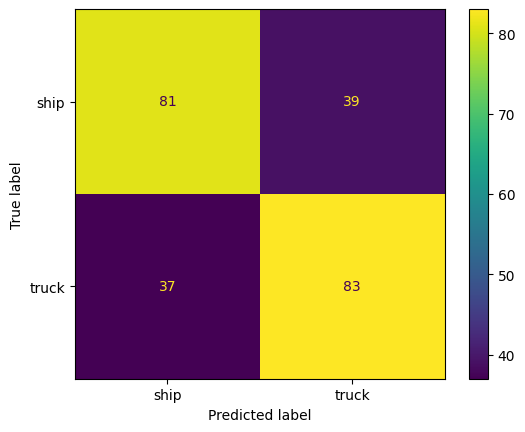

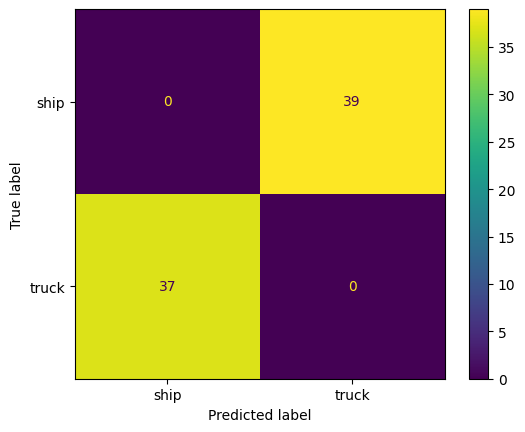

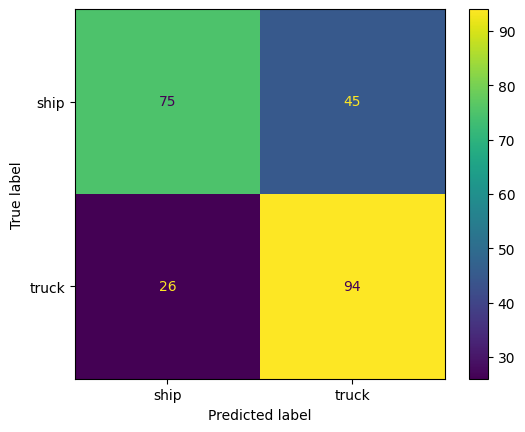

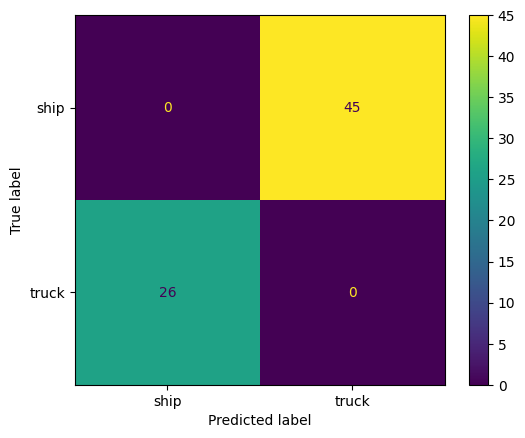

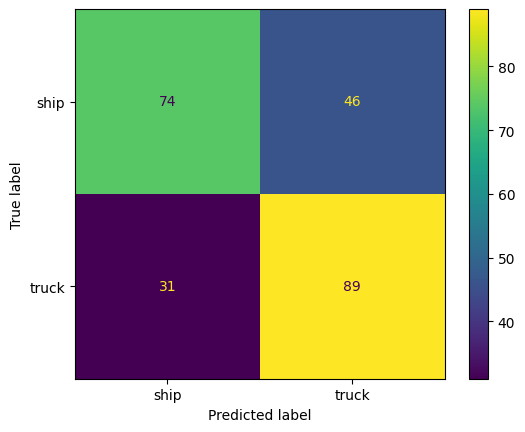

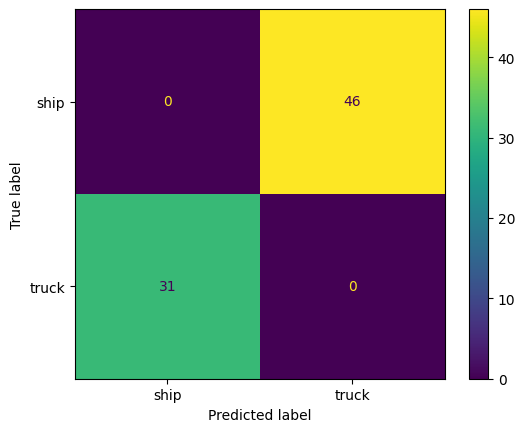

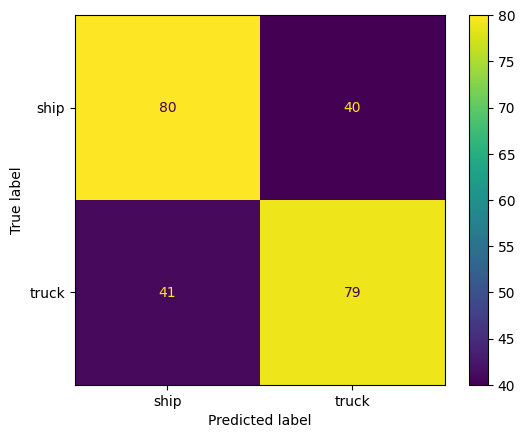

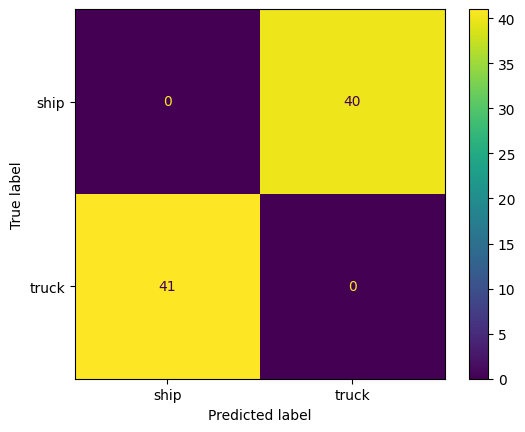

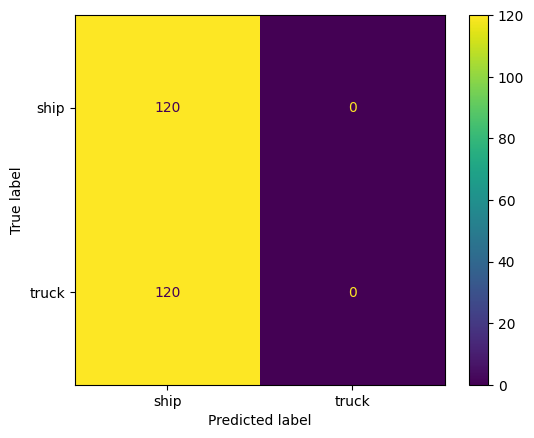

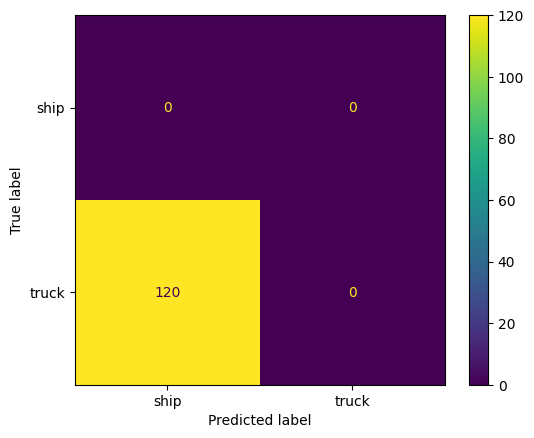

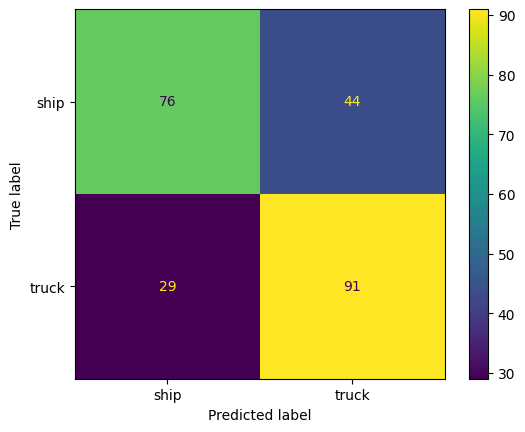

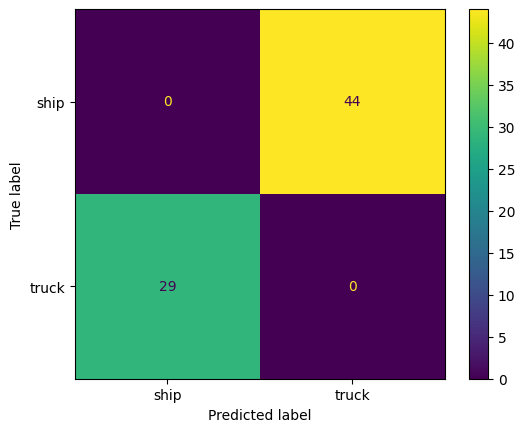

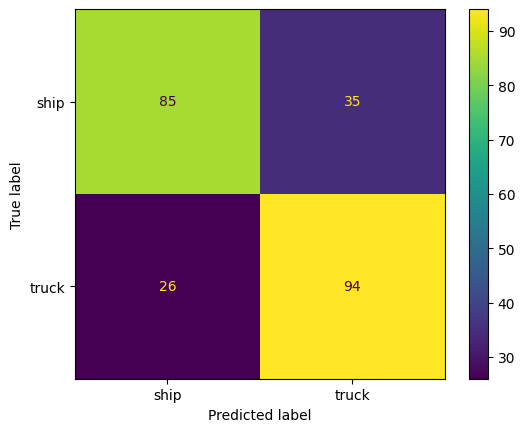

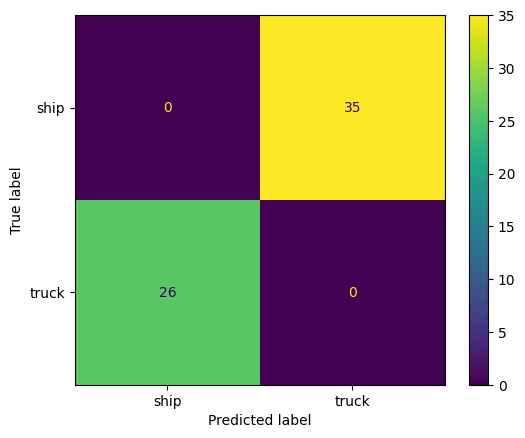

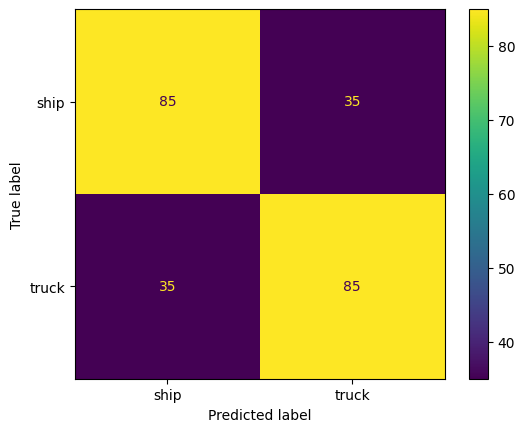

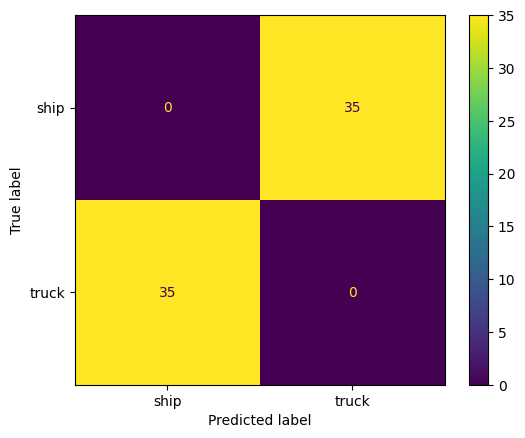

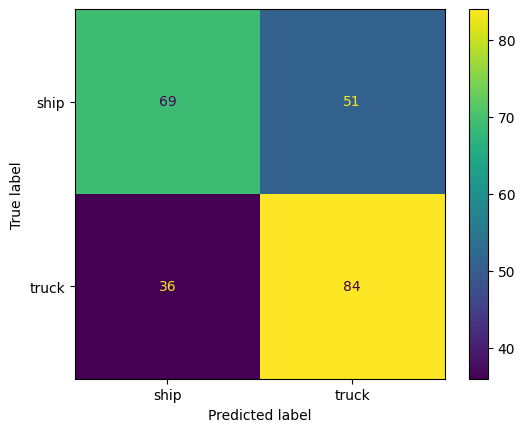

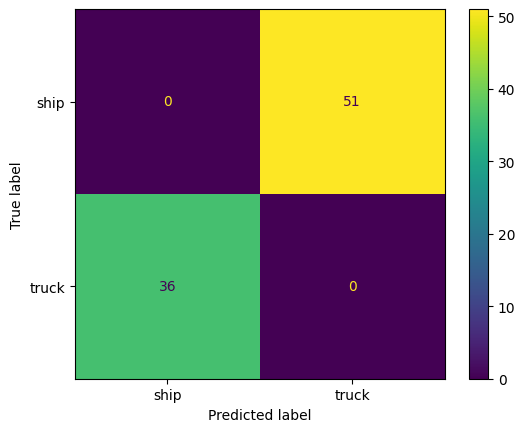

In [70]:
n_way = 6
n_shots = 5
c, h, w = 3, 32, 32
batch_size = 5
seed = 2

set_seed(seed)
ds_train, ds_valid, ds_test = get_cinic_few(FEW_SHOT_PATH, batch_size, n_shots)

configs = [
    {
        "seed": seed,
        "batch_size": batch_size,
        "train_n_way": n_way,
        "n_shots": n_shots,
        "checkpoint": os.path.join(CHECKPOINT_PATH, f"CAN_3_multisteplr_sgd_lr_0_1_mom_0_9_wdec_0_001_seed_{seed}"),
        "optimizer": "sgd",
        "optimizer_params": {
            "lr": 0.1,
            "momentum": 0.9,
            "weight_decay": 0.001,
        },
        "scheduler": "multistep",
        "scheduler_params": {
            "milestones": [50, 80, 100],
            "gamma": 0.3,
        },
        "epochs": 120,
        "warmup_epochs": 10,
        "min_residual_delta": 0.001,
        "patience": 15,
    },
    {
        "seed": seed,
        "batch_size": batch_size,
        "train_n_way": n_way,
        "n_shots": n_shots,
        "checkpoint": os.path.join(CHECKPOINT_PATH, f"CAN_3_multisteplr_sgd_lr_0_3_mom_0_9_wdec_0_001_seed_{seed}"),
        "optimizer": "sgd",
        "optimizer_params": {
            "lr": 0.3,
            "momentum": 0.9,
            "weight_decay": 0.001,
        },
        "scheduler": "multistep",
        "scheduler_params": {
            "milestones": [50, 80, 100],
            "gamma": 0.3,
        },
        "epochs": 120,
        "warmup_epochs": 10,
        "min_residual_delta": 0.001,
        "patience": 15,
    },
    {
        "seed": seed,
        "batch_size": batch_size,
        "train_n_way": n_way,
        "n_shots": n_shots,
        "checkpoint": os.path.join(CHECKPOINT_PATH, f"CAN_3_multisteplr_sgd_lr_0_03_mom_0_9_wdec_0_001_seed_{seed}"),
        "optimizer": "sgd",
        "optimizer_params": {
            "lr": 0.03,
            "momentum": 0.9,
            "weight_decay": 0.001,
        },
        "scheduler": "multistep",
        "scheduler_params": {
            "milestones": [50, 80, 100],
            "gamma": 0.3,
        },
        "epochs": 120,
        "warmup_epochs": 10,
        "min_residual_delta": 0.001,
        "patience": 15,
    },
    {
        "seed": seed,
        "batch_size": batch_size,
        "train_n_way": n_way,
        "n_shots": n_shots,
        "checkpoint": os.path.join(CHECKPOINT_PATH, f"CAN_3_multisteplr_sgd_lr_0_1_mom_0_9_wdec_0_01_seed_{seed}"),
        "optimizer": "sgd",
        "optimizer_params": {
            "lr": 0.1,
            "momentum": 0.9,
            "weight_decay": 0.01,
        },
        "scheduler": "multistep",
        "scheduler_params": {
            "milestones": [50, 80, 100],
            "gamma": 0.3,
        },
        "epochs": 120,
        "warmup_epochs": 10,
        "min_residual_delta": 0.001,
        "patience": 15,
    },
    {
        "seed": seed,
        "batch_size": batch_size,
        "train_n_way": n_way,
        "n_shots": n_shots,
        "checkpoint": os.path.join(CHECKPOINT_PATH, f"CAN_3_multisteplr_sgd_lr_0_3_mom_0_9_wdec_0_01_seed_{seed}"),
        "optimizer": "sgd",
        "optimizer_params": {
            "lr": 0.3,
            "momentum": 0.9,
            "weight_decay": 0.01,
        },
        "scheduler": "multistep",
        "scheduler_params": {
            "milestones": [50, 80, 100],
            "gamma": 0.3,
        },
        "epochs": 120,
        "warmup_epochs": 10,
        "min_residual_delta": 0.001,
        "patience": 15,
    },
    {
        "seed": seed,
        "batch_size": batch_size,
        "train_n_way": n_way,
        "n_shots": n_shots,
        "checkpoint": os.path.join(CHECKPOINT_PATH, f"CAN_3_multisteplr_sgd_lr_0_03_mom_0_9_wdec_0_01_seed_{seed}"),
        "optimizer": "sgd",
        "optimizer_params": {
            "lr": 0.03,
            "momentum": 0.9,
            "weight_decay": 0.01,
        },
        "scheduler": "multistep",
        "scheduler_params": {
            "milestones": [50, 80, 100],
            "gamma": 0.3,
        },
        "epochs": 120,
        "warmup_epochs": 10,
        "min_residual_delta": 0.001,
        "patience": 15,
    },
    {
        "seed": seed,
        "batch_size": batch_size,
        "train_n_way": n_way,
        "n_shots": n_shots,
        "checkpoint": os.path.join(CHECKPOINT_PATH, f"CAN_3_multisteplr_adamw_lr_0_001_wdec_0_01_seed_{seed}"),
        "optimizer": "adamw",
        "optimizer_params": {
            "lr": 0.001,
            "weight_decay": 0.01,
        },
        "scheduler": "multistep",
        "scheduler_params": {
            "milestones": [50, 80, 100],
            "gamma": 0.3,
        },
        "epochs": 120,
        "warmup_epochs": 10,
        "min_residual_delta": 0.001,
        "patience": 15,
    },
    {
        "seed": seed,
        "batch_size": batch_size,
        "train_n_way": n_way,
        "n_shots": n_shots,
        "checkpoint": os.path.join(CHECKPOINT_PATH, f"CAN_3_multisteplr_adamw_lr_0_1_wdec_0_01_seed_{seed}"),
        "optimizer": "adamw",
        "optimizer_params": {
            "lr": 0.1,
            "weight_decay": 0.01,
        },
        "scheduler": "multistep",
        "scheduler_params": {
            "milestones": [50, 80, 100],
            "gamma": 0.3,
        },
        "epochs": 120,
        "warmup_epochs": 10,
        "min_residual_delta": 0.001,
        "patience": 15,
    },
    {
        "seed": seed,
        "batch_size": batch_size,
        "train_n_way": n_way,
        "n_shots": n_shots,
        "checkpoint": os.path.join(CHECKPOINT_PATH, f"CAN_3_multisteplr_adamw_lr_0_01_wdec_0_01_seed_{seed}"),
        "optimizer": "adamw",
        "optimizer_params": {
            "lr": 0.01,
            "weight_decay": 0.01,
        },
        "scheduler": "multistep",
        "scheduler_params": {
            "milestones": [50, 80, 100],
            "gamma": 0.3,
        },
        "epochs": 120,
        "warmup_epochs": 10,
        "min_residual_delta": 0.001,
        "patience": 15,
    },
]

for config in configs:
    best_model, best_epoch, training_metrics, validation_metrics = train_model(ds_train, ds_valid, config)
    test_model(best_model, ds_test, config)